In [ ]:
# ============================================
# EXTRACTOR DE TRIAGE - VERSIÓN ROBUSTA
# Basada en la estructura real del documento
# ============================================

import re
import pandas as pd
from datetime import datetime
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("🚀 EXTRACTOR DE TRIAGE - VERSIÓN FINAL (POR ESTRUCTURA)")
print("="*60)

def extraer_campos(bloque):
    """Extrae todos los campos de un bloque individual de paciente."""
    datos = {}

    # ---------- IDENTIFICADOR (primeros 10 del CURP) ----------
    id_match = re.search(r'([A-Z0-9]{18})\s+\d{10}', bloque)
    datos['Identificador'] = id_match.group(1)[:10] if id_match else ''

    # ---------- FECHA DE ATENCIÓN (DDMMAA) ----------
    fecha_match = re.search(r'Fecha de atención:\s*(\d{1,2})-([a-z]+)\.-(\d{4})', bloque, re.IGNORECASE)
    if fecha_match:
        dia = fecha_match.group(1).zfill(2)
        mes_txt = fecha_match.group(2).lower()[:3]
        año = fecha_match.group(3)[-2:]
        meses = {'ene':'01','feb':'02','mar':'03','abr':'04','may':'05','jun':'06',
                 'jul':'07','ago':'08','sep':'09','oct':'10','nov':'11','dic':'12'}
        mes = meses.get(mes_txt, '00')
        datos['fecha_atencion'] = f"{dia}{mes}{año}"
    else:
        datos['fecha_atencion'] = ''

    # ---------- HORA DE ATENCIÓN ----------
    hora_match = re.search(r'Hora de atención:\s*(\d{2}:\d{2})', bloque)
    datos['hora_atencion'] = hora_match.group(1) if hora_match else ''

    # ---------- NIVEL DE ATENCIÓN ----------
    nivel_match = re.search(r'Nivel de Atención:\s*(\w+)', bloque)
    datos['nivel_atencion'] = nivel_match.group(1) if nivel_match else ''

    # ---------- AÑOS CUMPLIDOS (basado en "Procedencia:") ----------
    # Busca "Procedencia:" y luego un número seguido de "años"
    años_match = re.search(r'Procedencia:\s*\n\s*(\d+)\s*años', bloque, re.IGNORECASE)
    datos['años_cumplidos'] = años_match.group(1) if años_match else ''

    # ---------- GÉNERO (después de "días") ----------
    genero_match = re.search(r'\d+\s*d[ií]as\s*\n\s*(HOMBRE|MUJER)', bloque, re.IGNORECASE)
    if genero_match:
        datos['genero'] = genero_match.group(1).capitalize()
    else:
        datos['genero'] = ''

    # ---------- ENTIDAD (después del género) ----------
    entidad_match = re.search(r'(?:HOMBRE|MUJER)\s*\n\s*([A-ZÁ-Ú\s,]+?)(?:\n|$)', bloque, re.IGNORECASE)
    if entidad_match:
        datos['entidad'] = entidad_match.group(1).strip()
    else:
        datos['entidad'] = ''

    # ---------- DERIVACIÓN ----------
    derivacion_match = re.search(r'Derivación:\s*(.+?)(?:\n|$)', bloque, re.IGNORECASE)
    datos['derivacion'] = derivacion_match.group(1).strip() if derivacion_match else ''

    # ---------- ESPECIALIDAD ----------
    especialidad_match = re.search(r'Especialidad:\s*(.+?)(?:\n|$)', bloque, re.IGNORECASE)
    datos['especialidad'] = especialidad_match.group(1).strip() if especialidad_match else ''

    # ---------- MOTIVO DE ATENCIÓN (multilínea) ----------
    motivo_match = re.search(r'Motivo de Atención:\s*(.+?)(?=Impresión diagnóstica:|Presencia de:|Signos vitales:|$)',
                             bloque, re.IGNORECASE | re.DOTALL)
    if motivo_match:
        datos['motivo_atencion'] = motivo_match.group(1).strip().replace('\n', ' ')
    else:
        datos['motivo_atencion'] = ''

    # ---------- IMPRESIÓN DIAGNÓSTICA ----------
    impresion_match = re.search(r'Impresión diagnóstica:\s*(.+?)(?=Presencia de:|Signos vitales:|$)',
                                bloque, re.IGNORECASE | re.DOTALL)
    if impresion_match:
        datos['impresion_diagnostica'] = impresion_match.group(1).strip()
    else:
        datos['impresion_diagnostica'] = ''

    # ---------- ECG (GLASGOW) ----------
    glasgow_match = re.search(r'Glasgow \(puntos\)\s*\n\s*(\d+)', bloque, re.IGNORECASE)
    datos['ecg'] = glasgow_match.group(1) if glasgow_match else ''

    # ---------- SIGNOS VITALES ----------
    # TAS
    tas_match = re.search(r'TAS \(mmHg\)\s*\n\s*(\d+)', bloque, re.IGNORECASE)
    datos['tas'] = tas_match.group(1) if tas_match else ''
    # TAD
    tad_match = re.search(r'TAD \(mmHg\)\s*\n\s*(\d+)', bloque, re.IGNORECASE)
    datos['tad'] = tad_match.group(1) if tad_match else ''
    # FC
    fc_match = re.search(r'FC \(x´\)\s*\n\s*(\d+)', bloque, re.IGNORECASE)
    datos['fc'] = fc_match.group(1) if fc_match else ''
    # FR
    fr_match = re.search(r'FR \(x´\)\s*\n\s*(\d+)', bloque, re.IGNORECASE)
    datos['fr'] = fr_match.group(1) if fr_match else ''
    # Temperatura
    t_match = re.search(r'Temperatura \(°C\)\s*\n\s*(\d+(?:\.\d+)?)', bloque, re.IGNORECASE)
    datos['t'] = t_match.group(1) if t_match else ''
    # Saturación O2
    sao2_match = re.search(r'Saturación 02 \(%\)\s*\n\s*(\d+)', bloque, re.IGNORECASE)
    datos['sao2'] = sao2_match.group(1) if sao2_match else ''
    # Glucemia
    gluc_match = re.search(r'Glucemia Capilar \(mg/dL\)\s*\n\s*(\d+)', bloque, re.IGNORECASE)
    datos['gluc'] = gluc_match.group(1) if gluc_match else ''

    # ---------- ATENDIÓ ----------
    atendio_match = re.search(r'Atendió:\s*(.+?)(?:\n|$)', bloque, re.IGNORECASE)
    if atendio_match:
        datos['atendio'] = atendio_match.group(1).strip()
    else:
        datos['atendio'] = ''

    return datos

# ------------------------------------------------------------
# PROCESAMIENTO PRINCIPAL
# ------------------------------------------------------------
print("\n📁 PASO 1: Sube tu archivo .txt")
print("-" * 40)

uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    print(f"\n📄 Archivo cargado: {filename}")

    contenido = uploaded[filename].decode('utf-8', errors='ignore')
    print(f"📊 Tamaño: {len(contenido):,} caracteres")

    # Dividir por el separador de página (acepta con o sin acento)
    registros = re.split(r'--- P[ÁA]GINA \d+ ---', contenido)
    print(f"\n🔍 Procesando {len(registros)} registros...")

    todos = []
    contador = 0

    for i, bloque in enumerate(registros):
        bloque = bloque.strip()
        if not bloque:
            continue

        contador += 1
        if contador % 100 == 0:
            print(f"   Procesados {contador} registros...")

        try:
            datos = extraer_campos(bloque)
            # Agregar número de entrada
            datos['No. entrada'] = contador
            # Reordenar según el orden solicitado
            registro_ordenado = {
                'No. entrada': datos['No. entrada'],
                'Identificador': datos['Identificador'],
                'fecha_atencion': datos['fecha_atencion'],
                'hora_atencion': datos['hora_atencion'],
                'años_cumplidos': datos['años_cumplidos'],
                'genero': datos['genero'],
                'entidad': datos['entidad'],
                'derivacion': datos['derivacion'],
                'especialidad': datos['especialidad'],
                'nivel_atencion': datos['nivel_atencion'],
                'motivo_atencion': datos['motivo_atencion'],
                'impresion_diagnostica': datos['impresion_diagnostica'],
                'ecg': datos['ecg'],
                'tas': datos['tas'],
                'tad': datos['tad'],
                'fc': datos['fc'],
                'fr': datos['fr'],
                't': datos['t'],
                'sao2': datos['sao2'],
                'gluc': datos['gluc'],
                'atendio': datos['atendio']
            }
            todos.append(registro_ordenado)
        except Exception as e:
            print(f"⚠️  Error en registro {contador}: {e}")
            continue

    print(f"\n✅ Registros extraídos correctamente: {len(todos)}")

    if todos:
        df = pd.DataFrame(todos)

        # Vista previa
        print("\n👁️ VISTA PREVIA (primeros 5 registros):")
        print("-" * 80)
        display(df.head())

        # Estadísticas
        print("\n📊 ESTADÍSTICAS DE EXTRACCIÓN:")
        print(f"   Años cumplidos: {df['años_cumplidos'].astype(bool).sum()} / {len(df)}")
        print(f"   Género: {df['genero'].astype(bool).sum()} / {len(df)}")
        print(f"   Entidad: {df['entidad'].astype(bool).sum()} / {len(df)}")
        print(f"   ECG (Glasgow): {df['ecg'].astype(bool).sum()} / {len(df)}")
        print(f"   TAS: {df['tas'].astype(bool).sum()} / {len(df)}")

        # Guardar CSV
        csv_filename = f"triage_extraccion_final_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(csv_filename, index=False, encoding='utf-8')
        print(f"\n💾 Archivo CSV guardado: {csv_filename}")

        # Descargar
        print("\n⬇️ PASO 2: Descarga tu archivo CSV")
        print("-" * 40)
        files.download(csv_filename)
    else:
        print("❌ No se pudo extraer ningún registro.")
else:
    print("❌ No se cargó ningún archivo.")

🚀 EXTRACTOR DE TRIAGE - VERSIÓN FINAL (POR ESTRUCTURA)

📁 PASO 1: Sube tu archivo .txt
----------------------------------------


Saving dbrt.txt to dbrt (3).txt

📄 Archivo cargado: dbrt (3).txt
📊 Tamaño: 39,815,909 caracteres

🔍 Procesando 27051 registros...
   Procesados 100 registros...
   Procesados 200 registros...
   Procesados 300 registros...
   Procesados 400 registros...
   Procesados 500 registros...
   Procesados 600 registros...
   Procesados 700 registros...
   Procesados 800 registros...
   Procesados 900 registros...
   Procesados 1000 registros...
   Procesados 1100 registros...
   Procesados 1200 registros...
   Procesados 1300 registros...
   Procesados 1400 registros...
   Procesados 1500 registros...
   Procesados 1600 registros...
   Procesados 1700 registros...
   Procesados 1800 registros...
   Procesados 1900 registros...
   Procesados 2000 registros...
   Procesados 2100 registros...
   Procesados 2200 registros...
   Procesados 2300 registros...
   Procesados 2400 registros...
   Procesados 2500 registros...
   Procesados 2600 registros...
   Procesados 2700 registros...
   Procesados 2

,No. entrada,Identificador,fecha_atencion,hora_atencion,años_cumplidos,genero,entidad,derivacion,especialidad,nivel_atencion,...,impresion_diagnostica,ecg,tas,tad,fc,fr,t,sao2,gluc,atendio
0,1,AABP420925,140125,12:31,82,Hombre,CIUDAD DE MÉXICO,Consulta de Especialidad de Urgencias,CONSULTA URGENCIA,III,...,TCE LEVE,15,160,80,60,16,36.5,94,,Roberto Yamil Calderón Villarreal
1,2,LOEL981009,140125,12:40,26,Hombre,CIUDAD DE MÉXICO,Consulta de Especialidad de Urgencias,ORTOPEDIA,III,...,PB FX DE CLAVICULA IZQUIERDA,15,135,90,71,20,36.5,95,,Roberto Yamil Calderón Villarreal
2,3,ROHJ721011,140125,12:59,52,Hombre,CIUDAD DE MÉXICO,Consulta de Especialidad de Urgencias,CONSULTA URGENCIA,III,...,DOLOR TORACICO,15,130,56,140,16,37.4,92,,Roberto Yamil Calderón Villarreal
3,4,REPI490617,140125,13:18,75,Hombre,CIUDAD DE MÉXICO,Consulta de Especialidad de Urgencias,CONSULTA URGENCIA,II,...,PB IVU,15,67,46,81,16,36.2,91,146,Roberto Yamil Calderón Villarreal
4,5,LOGV641019,140125,13:33,60,Mujer,OAXACA,Consulta de Especialidad de Urgencias,ORTOPEDIA,III,...,FRACTURA WEBER C TOBILLO DERECHO,15,150,70,90,16,36.3,89,,Mireya Vega Gonzalez



📊 ESTADÍSTICAS DE EXTRACCIÓN:
   Años cumplidos: 25098 / 25809
   Género: 25096 / 25809
   Entidad: 25096 / 25809
   ECG (Glasgow): 24471 / 25809
   TAS: 25098 / 25809

💾 Archivo CSV guardado: triage_extraccion_final_20260211_165427.csv

⬇️ PASO 2: Descarga tu archivo CSV
----------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================
# LIMPIEZA DE CSV DE TRIAGE - NORMALIZACIÓN TOTAL
# ============================================
# 1. Instala unidecode (para reemplazar acentos y ñ)
# 2. Sube tu archivo CSV
# 3. Descarga el CSV limpio

!pip install unidecode -q

import pandas as pd
import unidecode
from datetime import datetime
from google.colab import files
import io

print("🧹 LIMPIADOR DE CSV - VERSIÓN FINAL")
print("="*60)

# ------------------------------------------------------------
# FUNCIÓN DE NORMALIZACIÓN (REEMPLAZA, NO SOLO ELIMINA)
# ------------------------------------------------------------
def normalizar_texto(texto):
    """
    - Convierte a string
    - Reemplaza caracteres Unicode por equivalentes ASCII (á → a, ñ → n, etc.)
    - Convierte a mayúsculas
    - Elimina espacios extras
    """
    if pd.isna(texto):
        return ""
    texto = str(texto)
    texto = unidecode.unidecode(texto)  # Á -> A, ñ -> n, etc.
    texto = texto.upper()
    texto = " ".join(texto.split())      # espacios múltiples -> uno solo
    return texto

# ------------------------------------------------------------
# INTERFAZ DE CARGA
# ------------------------------------------------------------
print("\n📁 PASO 1: Sube tu archivo CSV (el generado por el extractor)")
print("-" * 40)

uploaded = files.upload()

if not uploaded:
    print("❌ No se subió ningún archivo.")
else:
    filename = list(uploaded.keys())[0]
    print(f"\n📄 Archivo cargado: {filename}")

    # Leer CSV
    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
    print(f"📊 Dimensiones originales: {df.shape[0]} filas, {df.shape[1]} columnas")

    # --------------------------------------------------------
    # 1. ELIMINAR REGISTROS CON IDENTIFICADOR VACÍO
    # --------------------------------------------------------
    antes = len(df)
    df = df.dropna(subset=['Identificador'])                     # NaN
    df = df[df['Identificador'].astype(str).str.strip() != '']  # cadenas vacías
    despues = len(df)
    print(f"🗑️  Registros eliminados por Identificador vacío: {antes - despues}")

    # --------------------------------------------------------
    # 2. NORMALIZAR TODAS LAS COLUMNAS DE TEXTO
    # --------------------------------------------------------
    print("\n🔄 Normalizando campos de texto...")

    # Identificar columnas de tipo objeto (string)
    columnas_texto = df.select_dtypes(include=['object']).columns

    for col in columnas_texto:
        df[col] = df[col].apply(normalizar_texto)

    print(f"✅ Columnas normalizadas: {len(columnas_texto)}")

    # --------------------------------------------------------
    # VISTA PREVIA Y ESTADÍSTICAS
    # --------------------------------------------------------
    print("\n👁️ VISTA PREVIA (primeros 5 registros limpios):")
    print("-" * 80)
    display(df.head())

    print("\n📊 RESUMEN DE LIMPIEZA:")
    print(f"   Filas originales: {antes}")
    print(f"   Filas finales:    {despues}")
    print(f"   Eliminados:       {antes - despues}")
    print(f"   Columnas:         {df.shape[1]}")

    # --------------------------------------------------------
    # GUARDAR Y DESCARGAR
    # --------------------------------------------------------
    output_filename = f"triage_limpio_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df.to_csv(output_filename, index=False, encoding='utf-8')
    print(f"\n💾 Archivo guardado: {output_filename}")

    print("\n⬇️ PASO 2: Descarga tu CSV limpio")
    print("-" * 40)
    files.download(output_filename)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 3.1 MB/s eta 0:00:00
🧹 LIMPIADOR DE CSV - VERSIÓN FINAL

📁 PASO 1: Sube tu archivo CSV (el generado por el extractor)
----------------------------------------


Saving dbr.csv to dbr.csv

📄 Archivo cargado: dbr.csv
📊 Dimensiones originales: 25809 filas, 21 columnas
🗑️  Registros eliminados por Identificador vacío: 711

🔄 Normalizando campos de texto...
✅ Columnas normalizadas: 10

👁️ VISTA PREVIA (primeros 5 registros limpios):
--------------------------------------------------------------------------------


,No. entrada,Identificador,fecha_atencion,hora_atencion,años_cumplidos,genero,entidad,derivacion,especialidad,nivel_atencion,...,impresion_diagnostica,ecg,tas,tad,fc,fr,t,sao2,gluc,atendio
0,1,AABP420925,140125.0,12:31,82.0,HOMBRE,CIUDAD DE MEXICO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,III,...,TCE LEVE,15.0,160.0,80.0,60.0,16.0,36.5,94.0,NaN,ROBERTO YAMIL CALDERON VILLARREAL
1,2,LOEL981009,140125.0,12:40,26.0,HOMBRE,CIUDAD DE MEXICO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,ORTOPEDIA,III,...,PB FX DE CLAVICULA IZQUIERDA,15.0,135.0,90.0,71.0,20.0,36.5,95.0,NaN,ROBERTO YAMIL CALDERON VILLARREAL
2,3,ROHJ721011,140125.0,12:59,52.0,HOMBRE,CIUDAD DE MEXICO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,III,...,DOLOR TORACICO,15.0,130.0,56.0,140.0,16.0,37.4,92.0,NaN,ROBERTO YAMIL CALDERON VILLARREAL
3,4,REPI490617,140125.0,13:18,75.0,HOMBRE,CIUDAD DE MEXICO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,II,...,PB IVU,15.0,67.0,46.0,81.0,16.0,36.2,91.0,146.0,ROBERTO YAMIL CALDERON VILLARREAL
4,5,LOGV641019,140125.0,13:33,60.0,MUJER,OAXACA,CONSULTA DE ESPECIALIDAD DE URGENCIAS,ORTOPEDIA,III,...,FRACTURA WEBER C TOBILLO DERECHO,15.0,150.0,70.0,90.0,16.0,36.3,89.0,NaN,MIREYA VEGA GONZALEZ



📊 RESUMEN DE LIMPIEZA:
   Filas originales: 25809
   Filas finales:    25098
   Eliminados:       711
   Columnas:         21

💾 Archivo guardado: triage_limpio_20260211_171233.csv

⬇️ PASO 2: Descarga tu CSV limpio
----------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================
# FILTRADOR DE TOXICOLOGÍA - BÚSQUEDA SEMÁNTICA
# ============================================
# 1. Sube el CSV limpio
# 2. Filtra por palabras clave en 'motivo_atencion' e 'impresion_diagnostica'
# 3. Descarga CSV solo con casos toxicológicos

import pandas as pd
import re
from datetime import datetime
from google.colab import files
import io

print("🧪 FILTRADOR DE CASOS TOXICOLÓGICOS")
print("="*60)

# ------------------------------------------------------------
# DICCIONARIO DE PALABRAS CLAVE (AMPLIADO Y CON VARIANTES)
# ------------------------------------------------------------
TOXIC_KEYWORDS = {
    # Términos proporcionados por el usuario
    "SOBREINGESTA", "SOBRE INGESTA",
    "REACCION MEDICAMENTOS", "REACCION MEDICAMENTO",
    "PASTILLAS", "PASTILLA",
    "INTENTO SUICIDA", "AUTOLISIS",
    "ANIMAL", "ANIMALES",
    "INSECTO", "INSECTOS",
    "ARAÑA", "ARANA",  # sin acento
    "SERPIENTE", "SERPIENTES",
    "CASCABEL",
    "CAPULINA",
    "VIUDA NEGRA",
    "VIOLINISTA", "LOXO", "LOXOSCELES",
    "LATRO", "LATRODECTUS",
    "SOBREDOSIS", "SOBRE DOSIS",
    "TOXICO", "TOXICOS", "TOXICA", "TOXICAS",
    "TOXINDROME", "TOXINDROMES", "SINDROME TOXICO",
    "MORDEDURA", "MORDEDURAS",
    "PICADURA", "PICADURAS",
    "VENENO", "VENENOSA", "VENENOSO",
    "CLORO",
    "GAS", "GASES",
    "DETERGENTE", "DETERGENTES",
    "RATAS", "RATA", "ROEDOR",
    "RODENCITICIDA", "RODENTICIDA", "RATICIDA",
    "INSECTICIDA", "INSECTICIDAS",
    "HERBICIDA", "HERBICIDAS",
    "PLAGUICIDA", "PLAGUICIDAS",
    "PESTICIDA", "PESTICIDAS",
    "FUNGICIDA", "FUNGICIDAS",

    # Términos adicionales (toxicología clínica)
    "INTOXICACION", "INTOXICADO", "INTOXICADA",
    "ENVENENAMIENTO", "ENVENENADO",
    "ETANOL", "ALCOHOL", "ALCOHOLICA", "ALCOHOLISMO",
    "DROGA", "DROGAS", "DROGADO",
    "MARIHUANA", "CANNABIS",
    "COCAINA", "CRACK",
    "METANFETAMINA", "ANFETAMINA", "EFEDRINA",
    "OPIOIDE", "OPIOIDES", "HEROINA", "FENTANILO",
    "BENZODIAZEPINA", "BENZODIAZEPINAS", "CLONAZEPAM", "ALPRAZOLAM",
    "ANTIDEPRESIVO", "ANTIDEPRESIVOS",
    "ANTIPSICOTICO", "ANTIPSICOTICOS",
    "PARACETAMOL", "ACETAMINOFEN",
    "AINE", "IBUPROFENO", "NAPROXENO",
    "CARBAMAZEPINA", "FENITOINA", "VALPROICO",
    "DIGOXINA",
    "METANOL", "ETILENGLICOL",
    "MONOXIDO DE CARBONO", "CO", "HUMO",
    "CIANURO",
    "PARAQUAT",
    "ORGANOFOSFORADO", "ORGANOFOSFORADOS", "CARBAMATO",
    "PARATION",
    "ALACRAN", "ESCORPION",
    "ABEJA", "AVISPA",
    "PONZOÑA",

    # Prefijos y raíces (capturan variantes)
    "TOXIC",   # captura tóxico, toxicología, intoxicación
    "VENEN",   # veneno, envenenamiento
    "PICAD",   # picadura, picado
    "MORD",    # mordedura, mordido
    "SOBRED",  # sobredosis, sobredosificación
    "INGEST",  # ingestión, ingesta
    "SUICID",  # suicida, suicidio
    "AUTOLIS", # autolisis
}

# Compilar expresiones regulares para búsqueda flexible (palabra completa)
# Usamos límites de palabra para evitar falsos positivos (ej. "TOXIC" dentro de "ORTOPEDIA")
TOXIC_PATTERNS = [re.compile(rf'\b{re.escape(kw)}\b') for kw in TOXIC_KEYWORDS]

# ------------------------------------------------------------
# FUNCIÓN DE FILTRADO
# ------------------------------------------------------------
def es_caso_toxicologico(row):
    """
    Retorna True si el registro contiene al menos una palabra clave
    en 'motivo_atencion' o 'impresion_diagnostica'.
    """
    texto = ""
    if pd.notna(row.get('motivo_atencion')):
        texto += " " + str(row['motivo_atencion'])
    if pd.notna(row.get('impresion_diagnostica')):
        texto += " " + str(row['impresion_diagnostica'])

    texto = texto.upper()  # ya debería estar normalizado, pero por si acaso

    for pattern in TOXIC_PATTERNS:
        if pattern.search(texto):
            return True
    return False

# ------------------------------------------------------------
# INTERFAZ DE CARGA Y PROCESAMIENTO
# ------------------------------------------------------------
print("\n📁 PASO 1: Sube tu archivo CSV (el limpio)")
print("-" * 40)

uploaded = files.upload()

if not uploaded:
    print("❌ No se subió ningún archivo.")
else:
    filename = list(uploaded.keys())[0]
    print(f"\n📄 Archivo cargado: {filename}")

    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
    print(f"📊 Registros totales: {df.shape[0]}")

    # Verificar que existan las columnas necesarias
    columnas_necesarias = ['motivo_atencion', 'impresion_diagnostica']
    for col in columnas_necesarias:
        if col not in df.columns:
            print(f"⚠️  Columna '{col}' no encontrada. Se usará cadena vacía.")
            df[col] = ""

    # Aplicar filtro
    print("\n🔍 Buscando casos con palabras clave de toxicología...")
    df_filtrado = df[df.apply(es_caso_toxicologico, axis=1)].copy()

    # Resultados
    print(f"✅ Casos toxicológicos encontrados: {df_filtrado.shape[0]}")
    print(f"❌ Casos descartados: {df.shape[0] - df_filtrado.shape[0]}")

    if df_filtrado.empty:
        print("⚠️  No se encontraron casos. Revisa las palabras clave o el formato de los datos.")
    else:
        # Vista previa
        print("\n👁️ VISTA PREVIA (primeros 5 casos toxicológicos):")
        print("-" * 80)
        display(df_filtrado.head())

        # Guardar CSV
        output_filename = f"toxicologia_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df_filtrado.to_csv(output_filename, index=False, encoding='utf-8')
        print(f"\n💾 Archivo guardado: {output_filename}")

        # Descargar
        print("\n⬇️ PASO 2: Descarga tu CSV con casos toxicológicos")
        print("-" * 40)
        files.download(output_filename)

🧪 FILTRADOR DE CASOS TOXICOLÓGICOS

📁 PASO 1: Sube tu archivo CSV (el limpio)
----------------------------------------


Saving dbc.csv to dbc.csv

📄 Archivo cargado: dbc.csv
📊 Registros totales: 25098

🔍 Buscando casos con palabras clave de toxicología...
✅ Casos toxicológicos encontrados: 2131
❌ Casos descartados: 22967

👁️ VISTA PREVIA (primeros 5 casos toxicológicos):
--------------------------------------------------------------------------------


,No. entrada,Identificador,fecha_atencion,hora_atencion,años_cumplidos,genero,entidad,derivacion,especialidad,nivel_atencion,...,impresion_diagnostica,ecg,tas,tad,fc,fr,t,sao2,gluc,atendio
34,35,LOHC541005,140125.0,21:46,70.0,HOMBRE,NO APLICA,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CIRUGIA GENERAL,III,...,DOLOR ABDOMINAL EN ESTUDIO,15.0,149.0,84.0,106.0,16.0,36.0,95.0,NaN,VANIA DAFNE RODRIGUEZ SEGURA
39,41,SEHL371115,140125.0,23:18,87.0,HOMBRE,TLAXCALA,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,III,...,PB NAC,15.0,121.0,5.0,100.0,16.0,36.0,82.0,NaN,VANIA DAFNE RODRIGUEZ SEGURA
42,44,LOHC541005,140125.0,23:41,70.0,HOMBRE,NO APLICA,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,III,...,PB IVU,15.0,149.0,84.0,116.0,16.0,36.0,95.0,NaN,VANIA DAFNE RODRIGUEZ SEGURA
45,47,MIMM050425,150125.0,00:18,19.0,MUJER,CIUDAD DE MEXICO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,III,...,CEFALEA,15.0,114.0,76.0,65.0,16.0,36.0,98.0,NaN,VANIA DAFNE RODRIGUEZ SEGURA
80,84,PIRT580427,150125.0,16:26,66.0,MUJER,GUANAJUATO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,III,...,PB FX COSTAL,15.0,133.0,77.0,84.0,18.0,36.4,91.0,NaN,SINDY LUCERO ORTEGA MARTINEZ



💾 Archivo guardado: toxicologia_20260211_173241.csv

⬇️ PASO 2: Descarga tu CSV con casos toxicológicos
----------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================
# FILTRO DE TOXICOLOGÍA - SUPER ESTRICTO + NEWS2
# ============================================
# Reglas adicionales:
#   ❌ Excluye mordeduras de perro
#   ❌ Excluye especialidades distintas a URGENCIAS
#   ✅ Calcula NEWS-2 score automáticamente
#   ✅ Coloca la columna NEWS2 después de los signos vitales

import pandas as pd
import re
from datetime import datetime
from google.colab import files
import io
import numpy as np

print("☠️  FILTRO TOXICOLOGÍA + NEWS-2")
print("="*80)

# ------------------------------------------------------------
# PATRONES DE INTOXICACIÓN AGUDA (ALTA ESPECIFICIDAD)
# ------------------------------------------------------------
TOXIC_PATTERNS = [
    r'\bSOBREDOSIS\b', r'\bSOBRE\s+DOSIS\b', r'\bSOBREINGEST[AI]\b',
    r'\bINGEST[AIÓ]\s+DE\s+\d+\s*(TABLETAS?|COMPRIMIDOS?|PASTILLAS?|MG|ML|GRAMOS?|UNIDADES?)\b',
    r'\bCONSUMO\s+DE\s+\d+\s*(TABLETAS?|COMPRIMIDOS?|PASTILLAS?|MG|ML|GRAMOS?|UNIDADES?)\b',
    r'\bDOSIS\s+ÚNICA\s+DE\s+\d+\b', r'\bDOSIS\s+T[ÓO]XICA\b',
    r'\bINTENTO\s+DE?\s*SUICIDA?\b', r'\bAUTOLISIS\b',
    r'\bINTOXICACI[ÓO]N\s*(?:AGUDA|ET[ÍI]LICA|POR\s+[A-Z]+)?\b',
    r'\bINTOXICAD[OA]\b', r'\bENVENENAMIENTO\b', r'\bTOXINDROME\b',
    r'\bS[ÍI]NDROME\s+TOXICO\b', r'\bREACCI[ÓO]N\s+ADVERSA\b',
    r'\bMORDEDURA\s+DE\s+(ARAÑA|SERPIENTE|CASCABEL|VIUDA\s+NEGRA|VIOLINISTA|LOXO|LATRO|ALACRAN|ESCORPION)\b',
    r'\bPICADURA\s+DE\s+(ARAÑA|SERPIENTE|CASCABEL|VIUDA\s+NEGRA|VIOLINISTA|LOXO|LATRO|ALACRAN|ESCORPION|ABEJA|AVISPA)\b',
    r'\bEXPOSICI[ÓO]N\s+AGUDA\s+A\s+(CLORO|GAS|DETERGENTE|INSECTICIDA|HERBICIDA|PLAGUICIDA|RODENTICIDA|VENENO|PARAQUAT|ORGANOFOSFORADO|CARBAMATO|CIANURO|MONOXIDO|CO)\b',
    r'\bINHALACI[ÓO]N\s+DE\s+(GAS|HUMO|MONOXIDO|SOLVENTES?|PEGAMENTO)\b',
    r'\bINGEST[AÍ]\s+DE\s+(CLORO|DETERGENTE|INSECTICIDA|HERBICIDA|RATICIDA|VENENO|PILAS?|BATER[ÍI]AS?)\b',
    r'\bINTOXICACI[ÓO]N\s+ET[ÍI]LICA\b',
    r'\bSOBREDOSIS\s+DE\s+(ALCOHOL|ETANOL|DROGAS?|OPIOIDES?|HEROINA|COCAINA|MARIHUANA|METANFETAMINA|BENZODIAZEPINAS?)\b',
    r'\bINGEST[AÍ]\s+DE\s+(ALCOHOL|ETANOL|DROGAS?|OPIOIDES?|HEROINA|COCAINA|MARIHUANA|METANFETAMINA|BENZODIAZEPINAS?)\s+AGUDA\b',
    r'\bTOXICOLOGIA\b', r'\bCENTRO\s+TOXICOL[OÓ]GICO\b',
]
TOXIC_REGEX = [re.compile(p, re.IGNORECASE) for p in TOXIC_PATTERNS]

# ------------------------------------------------------------
# PATRONES DE EXCLUSIÓN (MORDEDURAS DE PERRO)
# ------------------------------------------------------------
EXCLUDE_PATTERNS = [
    r'\bMORDEDURA\s+DE\s+PERRO\b', r'\bMORDEDURA\s+CANINA?\b',
    r'\bMORDEDURA\s+DE\s+GATO\b', r'\bMORDEDURA\s+DE\s+ANIMAL\b',
]
EXCLUDE_REGEX = [re.compile(p, re.IGNORECASE) for p in EXCLUDE_PATTERNS]

# ------------------------------------------------------------
# FUNCIÓN DE FILTRADO (IGUAL QUE ANTES)
# ------------------------------------------------------------
def es_caso_valido(row):
    texto = ""
    if pd.notna(row.get('motivo_atencion')):
        texto += " " + str(row['motivo_atencion'])
    if pd.notna(row.get('impresion_diagnostica')):
        texto += " " + str(row['impresion_diagnostica'])
    texto = texto.upper()

    cumple_toxico = any(p.search(texto) for p in TOXIC_REGEX)
    if not cumple_toxico:
        return False

    for p in EXCLUDE_REGEX:
        if p.search(texto):
            return False

    especialidad = str(row.get('especialidad', '')).upper()
    especialidades_validas = ['CONSULTA URGENCIA', 'URGENCIAS', 'MEDICINA DE URGENCIAS', 'URGENCIA', 'CONSULTA DE URGENCIAS']
    palabras_excluir = ['ORTOPEDIA', 'CIRUG', 'TRAUMAT', 'GINEC', 'PEDIAT', 'MEDICINA INTERNA']

    if any(v in especialidad for v in especialidades_validas):
        return True
    if any(e in especialidad for e in palabras_excluir):
        return False
    if 'URGENC' in especialidad:
        return True
    return False

# ------------------------------------------------------------
# FUNCIÓN DE CÁLCULO DE NEWS-2
# ------------------------------------------------------------
def calcular_news2(row):
    """
    Calcula NEWS-2 score usando Glasgow como proxy de conciencia.
    Retorna el puntaje total si TODOS los campos requeridos existen y son numéricos,
    de lo contrario retorna cadena vacía.
    """
    try:
        # Convertir a float, manejar NaN, vacíos, '0' como ausencia de dato
        fr = float(row['fr']) if pd.notna(row['fr']) and str(row['fr']).strip() not in ['', '0'] else np.nan
        sao2 = float(row['sao2']) if pd.notna(row['sao2']) and str(row['sao2']).strip() not in ['', '0'] else np.nan
        tas = float(row['tas']) if pd.notna(row['tas']) and str(row['tas']).strip() not in ['', '0'] else np.nan
        fc = float(row['fc']) if pd.notna(row['fc']) and str(row['fc']).strip() not in ['', '0'] else np.nan
        t = float(row['t']) if pd.notna(row['t']) and str(row['t']).strip() not in ['', '0'] else np.nan
        glasgow = float(row['ecg']) if pd.notna(row['ecg']) and str(row['ecg']).strip() not in ['', '0'] else np.nan

        # Si falta algún campo, no calcular
        if any(np.isnan(x) for x in [fr, sao2, tas, fc, t, glasgow]):
            return ""

        # ---- FR ----
        if fr <= 8 or fr >= 25:
            pts_fr = 3
        elif 9 <= fr <= 11:
            pts_fr = 1
        elif 12 <= fr <= 20:
            pts_fr = 0
        elif 21 <= fr <= 24:
            pts_fr = 2
        else:
            pts_fr = 0

        # ---- SpO2 (escala 1, sin oxígeno) ----
        if sao2 >= 96:
            pts_o2 = 0
        elif 94 <= sao2 <= 95:
            pts_o2 = 1
        elif 92 <= sao2 <= 93:
            pts_o2 = 2
        else:  # ≤91
            pts_o2 = 3

        # ---- TAS ----
        if tas <= 90 or tas >= 220:
            pts_tas = 3
        elif 91 <= tas <= 100:
            pts_tas = 2
        elif 101 <= tas <= 110:
            pts_tas = 1
        elif 111 <= tas <= 219:
            pts_tas = 0
        else:
            pts_tas = 0

        # ---- FC ----
        if fc <= 40 or fc >= 131:
            pts_fc = 3
        elif 41 <= fc <= 50 or 91 <= fc <= 110:
            pts_fc = 1
        elif 111 <= fc <= 130:
            pts_fc = 2
        elif 51 <= fc <= 90:
            pts_fc = 0
        else:
            pts_fc = 0

        # ---- Temperatura ----
        if t <= 35.0:
            pts_t = 3
        elif 35.1 <= t <= 36.0 or 38.1 <= t <= 39.0:
            pts_t = 1
        elif t >= 39.1:
            pts_t = 2
        elif 36.1 <= t <= 38.0:
            pts_t = 0
        else:
            pts_t = 0

        # ---- Conciencia (Glasgow) ----
        pts_conscious = 0 if glasgow == 15 else 3

        total = pts_fr + pts_o2 + pts_tas + pts_fc + pts_t + pts_conscious
        return int(total)

    except (ValueError, TypeError):
        return ""

# ------------------------------------------------------------
# INTERFAZ DE CARGA Y PROCESAMIENTO
# ------------------------------------------------------------
print("\n📁 PASO 1: Sube tu archivo CSV (el limpio)")
print("-" * 40)

uploaded = files.upload()

if not uploaded:
    print("❌ No se subió ningún archivo.")
else:
    filename = list(uploaded.keys())[0]
    print(f"\n📄 Archivo cargado: {filename}")

    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
    total_original = df.shape[0]
    print(f"📊 Registros totales: {total_original}")

    # Verificar columnas
    if 'especialidad' not in df.columns:
        print("⚠️  Columna 'especialidad' no encontrada. NO se aplicará filtro por especialidad.")
        df['especialidad'] = ""
    for col in ['motivo_atencion', 'impresion_diagnostica']:
        if col not in df.columns:
            print(f"⚠️  Columna '{col}' no encontrada. Se usará cadena vacía.")
            df[col] = ""

    print("\n🔍 Aplicando filtro toxicológico super estricto...")
    df_filtrado = df[df.apply(es_caso_valido, axis=1)].copy()
    print(f"✅ Casos toxicológicos válidos: {df_filtrado.shape[0]}")
    print(f"❌ Casos descartados: {total_original - df_filtrado.shape[0]}")

    if df_filtrado.empty:
        print("⚠️  No se encontraron casos con los criterios actuales.")
    else:
        # ----- CÁLCULO DE NEWS-2 -----
        print("\n🧮 Calculando NEWS-2 score...")
        df_filtrado['news2_score'] = df_filtrado.apply(calcular_news2, axis=1)
        casos_con_news2 = df_filtrado['news2_score'].astype(str).str.strip().ne('').sum()
        print(f"   NEWS-2 calculado para {casos_con_news2} de {len(df_filtrado)} casos (datos completos)")

        # ----- REORDENAR COLUMNAS: NEWS2 después de gluc (signos vitales) -----
        columnas = df_filtrado.columns.tolist()
        # Buscar índice de 'gluc' (último signo vital)
        try:
            idx_gluc = columnas.index('gluc')
            # Insertar news2_score después de gluc
            columnas.remove('news2_score')
            columnas.insert(idx_gluc + 1, 'news2_score')
            df_filtrado = df_filtrado[columnas]
        except ValueError:
            # Si no encuentra 'gluc', lo deja al final
            print("   (columna 'gluc' no encontrada, NEWS2 se colocará al final)")

        # Vista previa
        print("\n👁️ VISTA PREVIA (primeros 5 casos):")
        print("-" * 80)
        display(df_filtrado.head())

        # Guardar CSV
        output_filename = f"toxicologia_news2_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df_filtrado.to_csv(output_filename, index=False, encoding='utf-8')
        print(f"\n💾 Archivo guardado: {output_filename}")

        print("\n⬇️ PASO 2: Descarga tu CSV con casos toxicológicos + NEWS-2")
        print("-" * 40)
        files.download(output_filename)

☠️  FILTRO TOXICOLOGÍA + NEWS-2

📁 PASO 1: Sube tu archivo CSV (el limpio)
----------------------------------------


Saving dbc.csv to dbc (2).csv

📄 Archivo cargado: dbc (2).csv
📊 Registros totales: 25098

🔍 Aplicando filtro toxicológico super estricto...
✅ Casos toxicológicos válidos: 195
❌ Casos descartados: 24903

🧮 Calculando NEWS-2 score...
   NEWS-2 calculado para 188 de 195 casos (datos completos)

👁️ VISTA PREVIA (primeros 5 casos):
--------------------------------------------------------------------------------


,No. entrada,Identificador,fecha_atencion,hora_atencion,años_cumplidos,genero,entidad,derivacion,especialidad,nivel_atencion,...,ecg,tas,tad,fc,fr,t,sao2,gluc,news2_score,atendio
213,218,DICA740504,180125.0,16:15,50.0,HOMBRE,GUERRERO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,II,...,15.0,117.0,73.0,88.0,20.0,36.5,89.0,NaN,3,MARCO ANTONIO LANDA ROSALES
533,557,RXTA960322,250125.0,10:21,28.0,MUJER,CIUDAD DE MEXICO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,III,...,15.0,113.0,3.0,96.0,15.0,36.3,93.0,NaN,3,MARIANA KRISTELL LOPEZ GORDILLO
834,867,SEPV050425,140225.0,09:45,19.0,HOMBRE,CIUDAD DE MEXICO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,III,...,13.0,100.0,74.0,119.0,18.0,36.7,90.0,NaN,10,MARTHA VIRIDIANA RIVERA VEGA
895,929,GUSK820618,150225.0,17:26,42.0,MUJER,GUERRERO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,III,...,15.0,112.0,86.0,82.0,20.0,36.7,95.0,NaN,1,HECTOR IGNACIO CEDILLO TORRES
926,961,TOBD870911,160225.0,10:35,37.0,MUJER,CIUDAD DE MEXICO,CONSULTA DE ESPECIALIDAD DE URGENCIAS,CONSULTA URGENCIA,II,...,15.0,100.0,69.0,66.0,22.0,36.5,95.0,NaN,5,MARCO ANTONIO LANDA ROSALES



💾 Archivo guardado: toxicologia_news2_20260211_182257.csv

⬇️ PASO 2: Descarga tu CSV con casos toxicológicos + NEWS-2
----------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================
# 📈 DASHBOARD TOXICOLÓGICO INTERACTIVO + NLP
# ============================================
# Versión profesional: gráficos modernos + análisis semántico de texto
# ============================================

!pip install -q plotly kaleido pandas numpy scipy wordcloud nltk

import pandas as pd
import numpy as np
from datetime import datetime
import io
import base64
import re
from collections import Counter

# Visualización moderna
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Análisis de texto
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')      # 👈 NUEVO (requerido)
nltk.download('punkt')          # 👈 Ya lo tenías
nltk.download('stopwords')      # 👈 Ya lo tenías
spanish_stopwords = set(stopwords.words('spanish'))

# Estadística
from scipy.stats import ttest_ind, f_oneway

from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("🚀 INICIANDO DASHBOARD TOXICOLÓGICO PROFESIONAL")
print("="*60)

# ------------------------------------------------------------
# 1. CARGA DE DATOS
# ------------------------------------------------------------
print("\n📁 PASO 1: Sube tu archivo CSV (con NEWS-2)")
print("-"*40)
uploaded = files.upload()
if not uploaded:
    raise Exception("❌ No se subió ningún archivo.")

filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
print(f"📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
df.columns = df.columns.str.strip()

# ------------------------------------------------------------
# 2. PREPROCESAMIENTO
# ------------------------------------------------------------
# Columnas numéricas
num_cols = ['años_cumplidos', 'tas', 'tad', 'fc', 'fr', 't', 'sao2', 'gluc', 'news2_score']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fecha/hora
if 'fecha_atencion' in df.columns:
    try:
        df['fecha_dt'] = pd.to_datetime(df['fecha_atencion'], format='%d%m%y', errors='coerce')
        df['dia_semana'] = df['fecha_dt'].dt.day_name()
        df['mes'] = df['fecha_dt'].dt.month
    except: pass

if 'hora_atencion' in df.columns:
    try:
        df['hora'] = pd.to_datetime(df['hora_atencion'], format='%H:%M', errors='coerce').dt.hour
    except: pass

# Normalizar género
if 'genero' in df.columns:
    df['genero'] = df['genero'].astype(str).str.upper().map({
        'HOMBRE': 'Hombre', 'MUJER': 'Mujer'
    }).fillna(df['genero'].str.capitalize())

# ------------------------------------------------------------
# 3. ANÁLISIS SEMÁNTICO: PALABRAS CLAVE EN TEXTO
# ------------------------------------------------------------
print("\n🔍 Analizando texto de motivos/impresiones...")

def extraer_palabras_clave(series, top_n=30):
    """Extrae palabras más frecuentes del texto (excluye stopwords)."""
    texto_completo = ' '.join(series.dropna().astype(str))
    tokens = word_tokenize(texto_completo.lower())
    palabras = [p for p in tokens if p.isalpha() and len(p) > 2 and p not in spanish_stopwords]
    return Counter(palabras).most_common(top_n)

# Unir motivo + impresión
df['texto_completo'] = df['motivo_atencion'].fillna('') + ' ' + df['impresion_diagnostica'].fillna('')
top_words = extraer_palabras_clave(df['texto_completo'], 40)

# Crear columnas dummy para las 20 palabras más relevantes
palabras_top = [w for w, _ in top_words[:20]]
for palabra in palabras_top:
    df[f'contiene_{palabra}'] = df['texto_completo'].str.lower().str.contains(palabra, na=False).astype(int)

# Prueba t para NEWS-2 según presencia de cada palabra
resultados_news = []
for palabra in palabras_top[:15]:  # top 15
    grupo_si = df[df[f'contiene_{palabra}'] == 1]['news2_score'].dropna()
    grupo_no = df[df[f'contiene_{palabra}'] == 0]['news2_score'].dropna()
    if len(grupo_si) > 5 and len(grupo_no) > 5:
        stat, p = ttest_ind(grupo_si, grupo_no, equal_var=False)
        resultados_news.append({
            'Palabra': palabra,
            'n (con palabra)': len(grupo_si),
            'NEWS-2 promedio (con)': grupo_si.mean(),
            'NEWS-2 promedio (sin)': grupo_no.mean(),
            'Diferencia': grupo_si.mean() - grupo_no.mean(),
            'p-valor': p,
            'Significativo': 'SÍ' if p < 0.05 else 'NO'
        })
df_semantico = pd.DataFrame(resultados_news).sort_values('p-valor')
print(f"✅ {len(df_semantico)} palabras con prueba estadística completada.")

# ------------------------------------------------------------
# 4. CONSTRUCCIÓN DEL DASHBOARD INTERACTIVO (GRID HTML)
# ------------------------------------------------------------
print("\n📊 GENERANDO DASHBOARD INTERACTIVO...")

# Configuración visual
COLOR_PRIMARY = "#2E86AB"
COLOR_SECONDARY = "#A23B72"
COLOR_ACCENT = "#F18F01"
TEMPLATE = "plotly_white"

# ----- FIGURA 1: Distribución de NEWS-2 -----
fig1 = px.histogram(df, x='news2_score', nbins=20,
                    title='Distribución de NEWS‑2',
                    labels={'news2_score': 'Puntaje NEWS‑2'},
                    color_discrete_sequence=[COLOR_PRIMARY],
                    opacity=0.8)
fig1.update_layout(bargap=0.1, title_x=0.5, template=TEMPLATE)

# ----- FIGURA 2: NEWS-2 vs Edad -----
fig2 = px.scatter(df, x='años_cumplidos', y='news2_score',
                  color='genero', trendline='ols',
                  title='NEWS‑2 vs. Edad por Género',
                  labels={'años_cumplidos': 'Edad (años)', 'news2_score': 'NEWS‑2'},
                  color_discrete_sequence=[COLOR_PRIMARY, COLOR_SECONDARY])
fig2.update_layout(title_x=0.5, template=TEMPLATE)

# ----- FIGURA 3: Boxplot NEWS-2 por grupo etario -----
df['grupo_edad'] = pd.cut(df['años_cumplidos'], bins=[0,18,30,45,60,100],
                           labels=['0-18','19-30','31-45','46-60','60+'])
fig3 = px.box(df, x='grupo_edad', y='news2_score', color='grupo_edad',
              title='NEWS‑2 por Grupo Etario',
              labels={'grupo_edad': 'Grupo de edad', 'news2_score': 'NEWS‑2'},
              color_discrete_sequence=px.colors.sequential.Viridis)
fig3.update_layout(title_x=0.5, template=TEMPLATE, showlegend=False)

# ----- FIGURA 4: Mapa de calor de correlaciones -----
corr_cols = ['años_cumplidos', 'tas', 'fc', 'fr', 't', 'sao2', 'news2_score']
corr = df[corr_cols].corr()
fig4 = px.imshow(corr, text_auto=True, aspect='auto',
                 title='Matriz de Correlación',
                 color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
fig4.update_layout(title_x=0.5, template=TEMPLATE)

# ----- FIGURA 5: Frecuencia por hora (línea) -----
df_hora = df['hora'].value_counts().sort_index().reset_index()
df_hora.columns = ['hora', 'frecuencia']
fig5 = px.line(df_hora, x='hora', y='frecuencia',
               title='Atenciones por Hora del Día',
               labels={'hora': 'Hora', 'frecuencia': 'Número de casos'},
               markers=True, color_discrete_sequence=[COLOR_ACCENT])
fig5.update_layout(title_x=0.5, template=TEMPLATE)

# ----- FIGURA 6: Treemap de entidades (solo si hay datos) -----
if df['entidad'].notna().any():
    entidad_counts = df['entidad'].value_counts().reset_index()
    entidad_counts.columns = ['entidad', 'casos']
    fig6 = px.treemap(entidad_counts, path=['entidad'], values='casos',
                      title='Distribución Geográfica de Casos',
                      color='casos', color_continuous_scale='Blues')
    fig6.update_layout(title_x=0.5, template=TEMPLATE)
else:
    fig6 = None

# ----- FIGURA 7: Impacto de palabras clave en NEWS-2 -----
if not df_semantico.empty:
    fig7 = go.Figure()
    fig7.add_trace(go.Bar(
        y=df_semantico.head(10)['Palabra'],
        x=df_semantico.head(10)['Diferencia'],
        orientation='h',
        marker=dict(color=df_semantico.head(10)['Diferencia'],
                    colorscale='RdBu_r',
                    showscale=True,
                    colorbar=dict(title="Δ NEWS‑2")),
        text=df_semantico.head(10)['Diferencia'].round(2),
        textposition='outside'
    ))
    fig7.update_layout(title='Impacto de Palabras Clave en NEWS‑2',
                       xaxis_title='Diferencia en NEWS‑2 (con - sin)',
                       yaxis_title='',
                       template=TEMPLATE,
                       height=500)
else:
    fig7 = None

# ------------------------------------------------------------
# 5. GENERAR HTML CON DISEÑO DE CUADRÍCULA (GRID)
# ------------------------------------------------------------
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8" />
    <title>Dashboard Toxicológico Interactivo</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {{
            font-family: 'Inter', -apple-system, BlinkMacSystemFont, sans-serif;
            background-color: #f9f9fb;
            margin: 0;
            padding: 20px;
        }}
        .dashboard {{
            max-width: 1400px;
            margin: 0 auto;
        }}
        h1 {{
            color: #2E86AB;
            font-weight: 600;
            border-bottom: 4px solid #F18F01;
            padding-bottom: 8px;
        }}
        .grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(600px, 1fr));
            gap: 25px;
            margin-top: 30px;
        }}
        .card {{
            background: white;
            border-radius: 16px;
            padding: 15px;
            box-shadow: 0 10px 25px rgba(0,0,0,0.03);
            transition: transform 0.2s;
            border: 1px solid #edf2f7;
        }}
        .card:hover {{
            box-shadow: 0 15px 35px rgba(0,0,0,0.05);
        }}
        .footer {{
            margin-top: 40px;
            text-align: center;
            color: #666;
            font-size: 0.85rem;
            border-top: 1px solid #ddd;
            padding-top: 20px;
        }}
    </style>
</head>
<body>
    <div class="dashboard">
        <h1>📊 Dashboard Toxicológico · {datetime.now().strftime('%d/%m/%Y')}</h1>
        <p style="color: #555;">{len(df)} casos analizados | NEWS‑2 calculado en {df['news2_score'].notna().sum()} pacientes</p>

        <div class="grid">
"""

# Función para agregar figura al grid
def add_figure_card(fig, title=None):
    if fig is None:
        return ""
    html_fig = fig.to_html(full_html=False, include_plotlyjs='cdn')
    card = f"""
            <div class="card">
                {html_fig}
            </div>
    """
    return card

# Agregar cada figura en orden
html_content += add_figure_card(fig1)
html_content += add_figure_card(fig2)
html_content += add_figure_card(fig3)
html_content += add_figure_card(fig4)
html_content += add_figure_card(fig5)
if fig6:
    html_content += add_figure_card(fig6)
if fig7:
    html_content += add_figure_card(fig7)

# Cerrar etiquetas
html_content += """
        </div>

        <div class="footer">
            <p>Dashboard generado automáticamente · Análisis de intoxicaciones agudas</p>
            <p style="font-size:0.75rem;">Los gráficos son interactivos: zoom, selección y descarga de PNG.</p>
        </div>
    </div>
</body>
</html>
"""

# ------------------------------------------------------------
# 6. GUARDAR Y DESCARGAR
# ------------------------------------------------------------
html_filename = f"dashboard_toxicologico_{datetime.now().strftime('%Y%m%d_%H%M%S')}.html"
with open(html_filename, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"\n💾 Dashboard HTML guardado: {html_filename}")

# También guardar análisis semántico como CSV
csv_semantico = f"analisis_palabras_news2_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df_semantico.to_csv(csv_semantico, index=False, encoding='utf-8')
print(f"💾 Análisis semántico guardado: {csv_semantico}")

# Descargar archivos
print("\n⬇️ DESCARGANDO DASHBOARD Y ANÁLISIS...")
files.download(html_filename)
files.download(csv_semantico)

print("\n🎯 ¡Dashboard listo! Abre el archivo HTML en tu navegador para explorar los datos de forma interactiva.")

🚀 INICIANDO DASHBOARD TOXICOLÓGICO PROFESIONAL

📁 PASO 1: Sube tu archivo CSV (con NEWS-2)
----------------------------------------


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving db-cinder-tox.csv to db-cinder-tox (3).csv
📊 Dimensiones: 195 filas × 22 columnas

🔍 Analizando texto de motivos/impresiones...
✅ 15 palabras con prueba estadística completada.

📊 GENERANDO DASHBOARD INTERACTIVO...

💾 Dashboard HTML guardado: dashboard_toxicologico_20260211_191851.html
💾 Análisis semántico guardado: analisis_palabras_news2_20260211_191851.csv

⬇️ DESCARGANDO DASHBOARD Y ANÁLISIS...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 ¡Dashboard listo! Abre el archivo HTML en tu navegador para explorar los datos de forma interactiva.


In [ ]:
# ============================================
# 📈 DASHBOARD TOXICOLÓGICO COMPLETO - TODO EN UNO
# ============================================
# Genera un HTML profesional con:
#   - 10+ gráficos interactivos (Plotly)
#   - Nube de palabras (WordCloud)
#   - Tabla de asociaciones significativas (p<0.05)
#   - Análisis semántico de texto
#   - Descarga automática del HTML y CSVs
# ============================================

!pip install -q plotly kaleido pandas numpy scipy wordcloud nltk

import pandas as pd
import numpy as np
from datetime import datetime
import io
import base64
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Visualización
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Nube de palabras
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# NLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
spanish_stopwords = set(stopwords.words('spanish'))

# Estadística
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr

from google.colab import files

print("🚀 GENERANDO DASHBOARD TOXICOLÓGICO COMPLETO")
print("="*60)

# ------------------------------------------------------------
# 1. CARGA DE DATOS
# ------------------------------------------------------------
print("\n📁 PASO 1: Sube tu archivo CSV (con NEWS-2)")
print("-"*40)
uploaded = files.upload()
if not uploaded:
    raise Exception("❌ No se subió ningún archivo.")
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
df.columns = df.columns.str.strip()
print(f"📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")

# ------------------------------------------------------------
# 2. PREPROCESAMIENTO
# ------------------------------------------------------------
num_cols = ['años_cumplidos', 'tas', 'tad', 'fc', 'fr', 't', 'sao2', 'gluc', 'news2_score']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fecha/hora
if 'fecha_atencion' in df.columns:
    try:
        df['fecha_dt'] = pd.to_datetime(df['fecha_atencion'], format='%d%m%y', errors='coerce')
        df['dia_semana'] = df['fecha_dt'].dt.day_name()
        df['mes'] = df['fecha_dt'].dt.month
    except: pass
if 'hora_atencion' in df.columns:
    try:
        df['hora'] = pd.to_datetime(df['hora_atencion'], format='%H:%M', errors='coerce').dt.hour
    except: pass

# Normalizar género
if 'genero' in df.columns:
    df['genero'] = df['genero'].astype(str).str.upper().map({
        'HOMBRE': 'Hombre', 'MUJER': 'Mujer'
    }).fillna(df['genero'].str.capitalize())

# Grupo etario
if 'años_cumplidos' in df.columns:
    df['grupo_edad'] = pd.cut(df['años_cumplidos'],
                               bins=[0, 18, 30, 45, 60, 100],
                               labels=['0-18', '19-30', '31-45', '46-60', '60+'])

# Texto completo para análisis semántico
df['texto_completo'] = df['motivo_atencion'].fillna('') + ' ' + df['impresion_diagnostica'].fillna('')

# ------------------------------------------------------------
# 3. ANÁLISIS SEMÁNTICO: PALABRAS CLAVE Y SU IMPACTO EN NEWS-2
# ------------------------------------------------------------
print("\n🔍 Analizando texto de motivos/impresiones...")

def extraer_palabras_clave(series, top_n=30):
    texto = ' '.join(series.dropna().astype(str))
    tokens = word_tokenize(texto.lower())
    palabras = [p for p in tokens if p.isalpha() and len(p) > 2 and p not in spanish_stopwords]
    return Counter(palabras).most_common(top_n)

top_words = extraer_palabras_clave(df['texto_completo'], 40)
palabras_top = [w for w, _ in top_words[:20]]

# Crear columnas dummy para las palabras más relevantes
for palabra in palabras_top:
    df[f'contiene_{palabra}'] = df['texto_completo'].str.lower().str.contains(palabra, na=False, regex=False).astype(int)

# Prueba t para NEWS-2 según presencia de cada palabra
resultados_palabras = []
for palabra in palabras_top[:15]:
    grupo_si = df[df[f'contiene_{palabra}'] == 1]['news2_score'].dropna()
    grupo_no = df[df[f'contiene_{palabra}'] == 0]['news2_score'].dropna()
    if len(grupo_si) >= 5 and len(grupo_no) >= 5:
        stat, p = ttest_ind(grupo_si, grupo_no, equal_var=False)
        resultados_palabras.append({
            'Palabra': palabra,
            'n (con)': len(grupo_si),
            'NEWS-2 (con)': round(grupo_si.mean(), 2),
            'NEWS-2 (sin)': round(grupo_no.mean(), 2),
            'Diferencia': round(grupo_si.mean() - grupo_no.mean(), 2),
            'p-valor': round(p, 4),
            'Significativo': 'SÍ' if p < 0.05 else 'NO'
        })
df_palabras = pd.DataFrame(resultados_palabras).sort_values('p-valor')
print(f"✅ {len(df_palabras)} palabras analizadas.")

# ------------------------------------------------------------
# 4. FUNCIONES DE PRUEBAS ESTADÍSTICAS
# ------------------------------------------------------------
def test_correlacion(df, var_num, var_target='news2_score'):
    x = df[var_num].dropna()
    y = df[var_target].dropna()
    common = x.index.intersection(y.index)
    if len(common) < 5:
        return None
    corr, p = pearsonr(x.loc[common], y.loc[common])
    return {
        'Variable': var_num,
        'Target': var_target,
        'Tipo': 'Correlación',
        'Estadístico': round(corr, 3),
        'p-valor': round(p, 4),
        'Significativo': 'SÍ' if p < 0.05 else 'NO',
        'n': len(common)
    }

def test_ttest_anova(df, var_cat, var_num='news2_score'):
    grupos = df[var_cat].dropna()
    if grupos.nunique() < 2:
        return None
    datos = [df[df[var_cat] == cat][var_num].dropna() for cat in grupos.unique()]
    if any(len(g) < 3 for g in datos):
        return None
    if len(datos) == 2:
        stat, p = ttest_ind(datos[0], datos[1], equal_var=False)
        tipo = 't-test'
    else:
        stat, p = f_oneway(*datos)
        tipo = 'ANOVA'
    return {
        'Variable': var_cat,
        'Target': var_num,
        'Tipo': tipo,
        'Estadístico': round(stat, 3),
        'p-valor': round(p, 4),
        'Significativo': 'SÍ' if p < 0.05 else 'NO',
        'Categorías': grupos.nunique()
    }

def test_chi2(df, var1, var2):
    tabla = pd.crosstab(df[var1], df[var2])
    chi2, p, dof, _ = chi2_contingency(tabla)
    return {
        'Variable 1': var1,
        'Variable 2': var2,
        'Tipo': 'Chi-cuadrado',
        'Estadístico': round(chi2, 3),
        'p-valor': round(p, 4),
        'Significativo': 'SÍ' if p < 0.05 else 'NO',
        'Grados libertad': dof
    }

# ------------------------------------------------------------
# 5. GENERAR TABLA DE ASOCIACIONES COMPLETA
# ------------------------------------------------------------
print("\n📊 Generando tabla de asociaciones con NEWS-2...")
resultados_asoc = []

# Numéricas vs NEWS-2
num_vars = ['años_cumplidos', 'tas', 'tad', 'fc', 'fr', 't', 'sao2', 'gluc']
for v in num_vars:
    if v in df.columns:
        res = test_correlacion(df, v, 'news2_score')
        if res:
            resultados_asoc.append(res)

# Categóricas vs NEWS-2
cat_vars = ['genero', 'nivel_atencion', 'entidad', 'dia_semana', 'grupo_edad']
for v in cat_vars:
    if v in df.columns and df[v].notna().sum() > 10:
        res = test_ttest_anova(df, v, 'news2_score')
        if res:
            resultados_asoc.append(res)

# Asociaciones entre categóricas relevantes
if 'genero' in df.columns and 'nivel_atencion' in df.columns:
    res = test_chi2(df, 'genero', 'nivel_atencion')
    if res:
        resultados_asoc.append(res)

df_asociaciones = pd.DataFrame(resultados_asoc).sort_values('p-valor')
print(f"✅ {len(df_asociaciones)} pruebas realizadas.")

# ------------------------------------------------------------
# 6. NUBE DE PALABRAS (imagen base64)
# ------------------------------------------------------------
print("☁️ Generando nube de palabras...")
texto_completo = ' '.join(df['texto_completo'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=50,
                      colormap='Blues',
                      collocations=False).generate(texto_completo)
fig_wc, ax_wc = plt.subplots(figsize=(10, 5))
ax_wc.imshow(wordcloud, interpolation='bilinear')
ax_wc.axis('off')
ax_wc.set_title('Nube de palabras en Motivo/Impresión', fontsize=16)
# Convertir a base64
buf = io.BytesIO()
fig_wc.savefig(buf, format='png', bbox_inches='tight', dpi=100)
buf.seek(0)
wordcloud_base64 = base64.b64encode(buf.read()).decode()
plt.close(fig_wc)

# ------------------------------------------------------------
# 7. CONSTRUCCIÓN DEL DASHBOARD HTML
# ------------------------------------------------------------
print("\n📝 Construyendo dashboard HTML...")

# Configuración visual
COLOR_PRIMARY = "#2E86AB"
COLOR_SECONDARY = "#A23B72"
COLOR_ACCENT = "#F18F01"
TEMPLATE = "plotly_white"

# ----- FIGURA 1: Distribución de NEWS-2 -----
fig1 = px.histogram(df, x='news2_score', nbins=20,
                    title='Distribución de NEWS‑2',
                    labels={'news2_score': 'Puntaje NEWS‑2'},
                    color_discrete_sequence=[COLOR_PRIMARY], opacity=0.8)
fig1.update_layout(bargap=0.1, title_x=0.5, template=TEMPLATE)

# ----- FIGURA 2: Violin plot NEWS-2 por género -----
fig2 = px.violin(df, x='genero', y='news2_score', box=True, points='all',
                 title='NEWS‑2 por Género',
                 color='genero',
                 color_discrete_sequence=[COLOR_PRIMARY, COLOR_SECONDARY])
fig2.update_layout(title_x=0.5, template=TEMPLATE, showlegend=False)

# ----- FIGURA 3: NEWS-2 vs Edad con regresión LOESS -----
fig3 = px.scatter(df, x='años_cumplidos', y='news2_score',
                  color='genero', trendline='lowess',
                  title='NEWS‑2 vs. Edad (suavizado)',
                  labels={'años_cumplidos': 'Edad (años)', 'news2_score': 'NEWS‑2'},
                  color_discrete_sequence=[COLOR_PRIMARY, COLOR_SECONDARY])
fig3.update_layout(title_x=0.5, template=TEMPLATE)

# ----- FIGURA 4: Boxplot NEWS-2 por grupo etario -----
fig4 = px.box(df, x='grupo_edad', y='news2_score', color='grupo_edad',
              title='NEWS‑2 por Grupo Etario',
              color_discrete_sequence=px.colors.sequential.Viridis)
fig4.update_layout(title_x=0.5, template=TEMPLATE, showlegend=False)

# ----- FIGURA 5: Matriz de correlación (ampliada) -----
corr_cols = ['años_cumplidos', 'tas', 'tad', 'fc', 'fr', 't', 'sao2', 'gluc', 'news2_score']
corr_cols = [c for c in corr_cols if c in df.columns]
corr = df[corr_cols].corr()
fig5 = px.imshow(corr, text_auto=True, aspect='auto',
                 title='Matriz de Correlación',
                 color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
fig5.update_layout(title_x=0.5, template=TEMPLATE)

# ----- FIGURA 6: Atenciones por hora (barras) -----
if 'hora' in df.columns:
    hora_counts = df['hora'].value_counts().sort_index().reset_index()
    hora_counts.columns = ['hora', 'casos']
    fig6 = px.bar(hora_counts, x='hora', y='casos',
                  title='Atenciones por Hora del Día',
                  labels={'hora': 'Hora', 'casos': 'Número de casos'},
                  color_discrete_sequence=[COLOR_ACCENT])
    fig6.update_layout(title_x=0.5, template=TEMPLATE)
else:
    fig6 = None

# ----- FIGURA 7: Treemap de entidades -----
if 'entidad' in df.columns and df['entidad'].notna().any():
    entidad_counts = df['entidad'].value_counts().reset_index()
    entidad_counts.columns = ['entidad', 'casos']
    fig7 = px.treemap(entidad_counts, path=['entidad'], values='casos',
                      title='Distribución Geográfica de Casos',
                      color='casos', color_continuous_scale='Blues')
    fig7.update_layout(title_x=0.5, template=TEMPLATE)
else:
    fig7 = None

# ----- FIGURA 8: Impacto de palabras clave en NEWS-2 -----
if not df_palabras.empty and 'Diferencia' in df_palabras.columns:
    df_palabras_plot = df_palabras.sort_values('Diferencia', ascending=False).head(10)
    fig8 = go.Figure()
    fig8.add_trace(go.Bar(
        y=df_palabras_plot['Palabra'],
        x=df_palabras_plot['Diferencia'],
        orientation='h',
        marker=dict(color=df_palabras_plot['Diferencia'],
                    colorscale='RdBu_r',
                    showscale=True,
                    colorbar=dict(title="Δ NEWS‑2")),
        text=df_palabras_plot['Diferencia'].round(2),
        textposition='outside'
    ))
    fig8.update_layout(title='Impacto de Palabras Clave en NEWS‑2',
                       xaxis_title='Diferencia (con - sin)',
                       yaxis_title='',
                       template=TEMPLATE,
                       height=500)
else:
    fig8 = None

# ----- FIGURA 9: Gráfico de barras apiladas (Género vs Nivel de Atención) -----
if 'genero' in df.columns and 'nivel_atencion' in df.columns:
    tabla_gen_nivel = pd.crosstab(df['genero'], df['nivel_atencion'])
    fig9 = px.bar(tabla_gen_nivel, barmode='stack',
                  title='Nivel de Atención por Género',
                  labels={'value': 'Número de casos', 'nivel_atencion': 'Nivel'},
                  color_discrete_sequence=px.colors.qualitative.Set2)
    fig9.update_layout(title_x=0.5, template=TEMPLATE)
else:
    fig9 = None

# ------------------------------------------------------------
# FUNCIÓN AUXILIAR PARA INSERTAR FIGURAS EN HTML
# ------------------------------------------------------------
def fig_to_html_card(fig):
    if fig is None:
        return ""
    html_fig = fig.to_html(full_html=False, include_plotlyjs=False)
    return f'<div class="card">{html_fig}</div>'

# ------------------------------------------------------------
# CONSTRUIR HTML FINAL
# ------------------------------------------------------------
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Dashboard Toxicológico Completo</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {{
            font-family: 'Inter', -apple-system, BlinkMacSystemFont, sans-serif;
            background-color: #f9f9fb;
            margin: 0;
            padding: 25px;
        }}
        .dashboard {{
            max-width: 1600px;
            margin: 0 auto;
        }}
        h1 {{
            color: {COLOR_PRIMARY};
            font-weight: 600;
            border-bottom: 4px solid {COLOR_ACCENT};
            padding-bottom: 8px;
        }}
        .stats-grid {{
            display: flex;
            flex-wrap: wrap;
            gap: 20px;
            margin: 30px 0;
        }}
        .stat-card {{
            background: white;
            border-radius: 14px;
            padding: 20px 25px;
            box-shadow: 0 8px 20px rgba(0,0,0,0.02);
            border-top: 6px solid {COLOR_ACCENT};
            flex: 1 1 160px;
        }}
        .stat-number {{
            font-size: 2.2rem;
            font-weight: 700;
            color: {COLOR_PRIMARY};
            line-height: 1.2;
        }}
        .stat-label {{
            font-size: 0.85rem;
            text-transform: uppercase;
            color: #5f6b7a;
            letter-spacing: 0.5px;
        }}
        .grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(650px, 1fr));
            gap: 25px;
            margin-top: 30px;
        }}
        .card {{
            background: white;
            border-radius: 18px;
            padding: 20px;
            box-shadow: 0 12px 30px rgba(0,0,0,0.03);
            border: 1px solid #edf2f7;
            transition: all 0.2s;
        }}
        .card:hover {{
            box-shadow: 0 18px 40px rgba(0,0,0,0.05);
        }}
        .table-container {{
            overflow-x: auto;
            margin: 25px 0;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            font-size: 0.9rem;
            background: white;
            border-radius: 14px;
        }}
        th {{
            background-color: {COLOR_PRIMARY};
            color: white;
            padding: 12px 10px;
            font-weight: 600;
        }}
        td {{
            padding: 10px;
            border-bottom: 1px solid #e2e8f0;
        }}
        tr:hover {{
            background-color: #f1f5f9;
        }}
        .footer {{
            margin-top: 50px;
            text-align: center;
            color: #64748b;
            border-top: 1px solid #e2e8f0;
            padding-top: 25px;
            font-size: 0.8rem;
        }}
        .alert {{
            background: #e6f7ff;
            border-left: 6px solid #1890ff;
            padding: 18px;
            border-radius: 12px;
            margin-bottom: 25px;
        }}
        .significant {{
            background-color: #d4edda;
            font-weight: 600;
        }}
    </style>
</head>
<body>
    <div class="dashboard">
        <h1>📊 Dashboard Toxicológico · Análisis Completo</h1>
        <p style="color: #475569; font-size: 1.1rem;">
            {datetime.now().strftime('%d/%m/%Y %H:%M')} · {len(df)} casos · NEWS‑2 disponible en {df['news2_score'].notna().sum()} pacientes
        </p>

        <!-- Tarjetas de resumen -->
        <div class="stats-grid">
            <div class="stat-card"><span class="stat-number">{len(df)}</span><div class="stat-label">Total casos</div></div>
            <div class="stat-card"><span class="stat-number">{df['genero'].value_counts().get('Hombre', 0)}</span><div class="stat-label">Hombres</div></div>
            <div class="stat-card"><span class="stat-number">{df['genero'].value_counts().get('Mujer', 0)}</span><div class="stat-label">Mujeres</div></div>
            <div class="stat-card"><span class="stat-number">{df['años_cumplidos'].median():.0f}</span><div class="stat-label">Edad mediana</div></div>
            <div class="stat-card"><span class="stat-number">{df['news2_score'].mean():.1f}</span><div class="stat-label">NEWS‑2 promedio</div></div>
        </div>

        <!-- Hallazgos significativos (alertas) -->
        <div class="alert">
            <strong>🔍 Hallazgos estadísticamente significativos (p < 0.05):</strong><br>
"""

# Agregar alertas dinámicamente
significativos = df_asociaciones[df_asociaciones['Significativo'] == 'SÍ']
if len(significativos) > 0:
    for _, row in significativos.head(5).iterrows():
        html_content += f"• {row['Variable']} vs {row.get('Target', row.get('Variable 2', 'NEWS-2'))}: "
        html_content += f"{row['Tipo']} = {row['Estadístico']}, p = {row['p-valor']}<br>"
else:
    html_content += "• No se encontraron asociaciones significativas con p<0.05 en esta muestra.<br>"

html_content += """
        </div>

        <!-- Grid de gráficos -->
        <div class="grid">
"""

# Insertar figuras
html_content += fig_to_html_card(fig1)
html_content += fig_to_html_card(fig2)
html_content += fig_to_html_card(fig3)
html_content += fig_to_html_card(fig4)
html_content += fig_to_html_card(fig5)
if fig6: html_content += fig_to_html_card(fig6)
if fig7: html_content += fig_to_html_card(fig7)
if fig8: html_content += fig_to_html_card(fig8)
if fig9: html_content += fig_to_html_card(fig9)

# Insertar nube de palabras como card
html_content += f"""
            <div class="card">
                <h3 style="margin-top:0; color:{COLOR_PRIMARY};">☁️ Nube de palabras</h3>
                <img src="data:image/png;base64,{wordcloud_base64}" style="width:100%; border-radius:12px;">
            </div>
"""

# Tabla de asociaciones completa
html_content += f"""
            <div class="card" style="grid-column: 1/-1;">
                <h3 style="color:{COLOR_PRIMARY};">📋 Tabla de asociaciones con NEWS‑2</h3>
                <div class="table-container">
                    {df_asociaciones.to_html(index=False, classes='table', border=0, escape=False)}
                </div>
                <p style="font-size:0.85rem; color:#64748b; margin-top:10px;">
                    * Pruebas: correlación de Pearson, t-test/ANOVA, Chi-cuadrado. Se muestran solo variables con suficientes datos.
                </p>
            </div>
"""

# Análisis semántico detallado (top palabras)
if not df_palabras.empty:
    html_content += f"""
            <div class="card" style="grid-column: 1/-1;">
                <h3 style="color:{COLOR_PRIMARY};">🔤 Impacto de palabras clave en NEWS‑2</h3>
                <div class="table-container">
                    {df_palabras.head(15).to_html(index=False, classes='table', border=0, escape=False)}
                </div>
            </div>
    """

html_content += """
        </div> <!-- fin grid -->

        <div class="footer">
            Dashboard generado automáticamente · Análisis de intoxicaciones agudas · Herramienta desarrollada para investigación clínica.
        </div>
    </div>
</body>
</html>
"""

# ------------------------------------------------------------
# 8. GUARDAR Y DESCARGAR
# ------------------------------------------------------------
html_filename = f"dashboard_toxicologico_completo_{datetime.now().strftime('%Y%m%d_%H%M%S')}.html"
with open(html_filename, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"\n💾 Dashboard HTML guardado: {html_filename}")

# Guardar CSVs de resultados
csv_asoc = f"asociaciones_news2_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df_asociaciones.to_csv(csv_asoc, index=False, encoding='utf-8')
print(f"💾 Tabla de asociaciones guardada: {csv_asoc}")

if not df_palabras.empty:
    csv_palabras = f"analisis_palabras_news2_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df_palabras.to_csv(csv_palabras, index=False, encoding='utf-8')
    print(f"💾 Análisis de palabras guardado: {csv_palabras}")

# Descargar todo
print("\n⬇️ DESCARGANDO ARCHIVOS...")
files.download(html_filename)
files.download(csv_asoc)
if not df_palabras.empty:
    files.download(csv_palabras)

print("\n🎯 ¡Proceso completado! El dashboard HTML contiene todos los gráficos y tablas.")


🚀 GENERANDO DASHBOARD TOXICOLÓGICO COMPLETO

📁 PASO 1: Sube tu archivo CSV (con NEWS-2)
----------------------------------------


Saving db-cinder-tox.csv to db-cinder-tox.csv
📊 Dimensiones: 195 filas × 22 columnas

🔍 Analizando texto de motivos/impresiones...
✅ 15 palabras analizadas.

📊 Generando tabla de asociaciones con NEWS-2...
✅ 12 pruebas realizadas.
☁️ Generando nube de palabras...

📝 Construyendo dashboard HTML...

💾 Dashboard HTML guardado: dashboard_toxicologico_completo_20260211_200425.html
💾 Tabla de asociaciones guardada: asociaciones_news2_20260211_200425.csv
💾 Análisis de palabras guardado: analisis_palabras_news2_20260211_200425.csv

⬇️ DESCARGANDO ARCHIVOS...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 ¡Proceso completado! El dashboard HTML contiene todos los gráficos y tablas.


In [ ]:
# ============================================
# 📁 SCRIPT 1 - ENRIQUECIMIENTO DE DATOS TOXICOLÓGICOS
# ============================================
# 1. Carga el CSV original (con 'motivo_atencion' e 'impresion_diagnostica')
# 2. Extrae variables: tipo de tóxico, intencionalidad, polifarmacia, co-ingesta de alcohol
# 3. Guarda un CSV enriquecido para análisis posteriores
# ============================================

import pandas as pd
import re
import io
from google.colab import files

print("🚀 INICIANDO ENRIQUECIMIENTO DE DATOS")
print("="*60)

# ------------------------------------------------------------
# 1. CARGA DEL ARCHIVO CSV ORIGINAL
# ------------------------------------------------------------
print("\n📁 PASO 1: Sube tu archivo CSV (con motivo_atencion e impresion_diagnostica)")
uploaded = files.upload()
if not uploaded:
    raise Exception("❌ No se subió ningún archivo.")

filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
df.columns = df.columns.str.strip()
print(f"📊 Dimensiones originales: {df.shape[0]} filas × {df.shape[1]} columnas")

# ------------------------------------------------------------
# 2. PREPARAR TEXTO COMBINADO (manejo de NaN)
# ------------------------------------------------------------
df['motivo_atencion'] = df['motivo_atencion'].fillna('')
df['impresion_diagnostica'] = df['impresion_diagnostica'].fillna('')
texto = (df['motivo_atencion'] + ' ' + df['impresion_diagnostica']).str.lower()

# ------------------------------------------------------------
# 3. EXTRACCIÓN DE VARIABLES SEMÁNTICAS
# ------------------------------------------------------------
print("\n🔍 Extrayendo variables semánticas...")

# Diccionario de términos
TOXICOS = {
    'benzodiacepina': ['clonazepam', 'alprazolam', 'diazepam', 'lorazepam', 'benzodiacepina'],
    'antidepresivo': ['fluoxetina', 'sertralina', 'paroxetina', 'citalopram', 'antidepresivo'],
    'antipsicotico': ['risperidona', 'quetiapina', 'olanzapina', 'haloperidol'],
    'analgesico': ['paracetamol', 'ibuprofeno', 'naproxeno', 'diclofenaco', 'tramadol'],
    'alcohol': ['alcohol', 'etanol', 'etilica', 'embriaguez'],
    'droga_ilegal': ['cocaina', 'marihuana', 'cannabis', 'heroina', 'metanfetamina'],
    'plaguicida': ['insecticida', 'herbicida', 'rodenticida', 'paration', 'paraquat'],
    'animal': ['araña', 'alacran', 'serpiente', 'cascabel', 'viuda', 'violinista']
}

for cat, palabras in TOXICOS.items():
    pattern = '|'.join(palabras)
    df[f'tox_{cat}'] = texto.str.contains(pattern, na=False).astype(int)

# Intencionalidad
intencion_pattern = r'\b(intento|autolisis|suicida|autoagresion)\b'
df['intencional'] = texto.str.contains(intencion_pattern, na=False).astype(int)

# Polifarmacia (número de fármacos distintos mencionados)
farmacos_pattern = r'\b(clonazepam|alprazolam|fluoxetina|sertralina|risperidona|quetiapina|paracetamol|ibuprofeno|tramadol)\b'
df['num_farmacos'] = texto.str.findall(farmacos_pattern).apply(len)

# Co-ingesta de alcohol
df['con_alcohol'] = texto.str.contains(r'\b(alcohol|etanol)\b', na=False).astype(int)

# Tipo de tóxico principal (el primero que aparezca, para análisis cualitativo)
def tipo_principal(texto):
    for cat in TOXICOS.keys():
        if any(palabra in texto for palabra in TOXICOS[cat]):
            return cat
    return 'otro'

df['tipo_toxico_principal'] = texto.apply(tipo_principal)

print(f"✅ Se crearon {len(df.columns) - df.shape[1]} nuevas variables.")
print("   Columnas añadidas:", [col for col in df.columns if col.startswith('tox_') or col in ['intencional', 'num_farmacos', 'con_alcohol', 'tipo_toxico_principal']])

# ------------------------------------------------------------
# 4. GUARDAR CSV ENRIQUECIDO
# ------------------------------------------------------------
output_filename = "datos_toxicologia_enriquecidos.csv"
df.to_csv(output_filename, index=False, encoding='utf-8')
print(f"\n💾 CSV enriquecido guardado: {output_filename}")

# Descargar
files.download(output_filename)
print("\n⬇️ Archivo descargado. Ya puedes usar este CSV en el SCRIPT 2.")

🚀 INICIANDO ENRIQUECIMIENTO DE DATOS

📁 PASO 1: Sube tu archivo CSV (con motivo_atencion e impresion_diagnostica)


KeyboardInterrupt: 

🚀 INICIANDO ANÁLISIS EXPLORATORIO AVANZADO

📁 PASO 1: Sube el archivo 'datos_toxicologia_enriquecidos.csv'


Saving db-cinder-tox-mod.csv to db-cinder-tox-mod.csv
📊 Dimensiones: 195 filas × 34 columnas
   Columnas disponibles: ['No. entrada', 'Identificador', 'fecha_atencion', 'hora_atencion', 'años_cumplidos', 'genero', 'entidad', 'derivacion', 'especialidad', 'nivel_atencion', 'motivo_atencion', 'impresion_diagnostica', 'ecg', 'tas', 'tad', 'fc', 'fr', 't', 'sao2', 'gluc', 'news2_score', 'atendio', 'tox_benzodiacepina', 'tox_antidepresivo', 'tox_antipsicotico', 'tox_analgesico', 'tox_alcohol', 'tox_droga_ilegal', 'tox_plaguicida', 'tox_animal', 'intencional', 'num_farmacos', 'con_alcohol', 'tipo_toxico_principal']

✅ Muestra para modelado: 193 casos, 18 características.

🌲 Entrenando Random Forest para predecir NEWS-2 ≥ 5...

🌟 TOP 10 PREDICTORES DE NEWS-2 ≥ 5:
          Variable  Importancia
                fr     0.243295
               tas     0.175091
                fc     0.137793
               tad     0.095860
              sao2     0.092050
                 t     0.075987
    años_

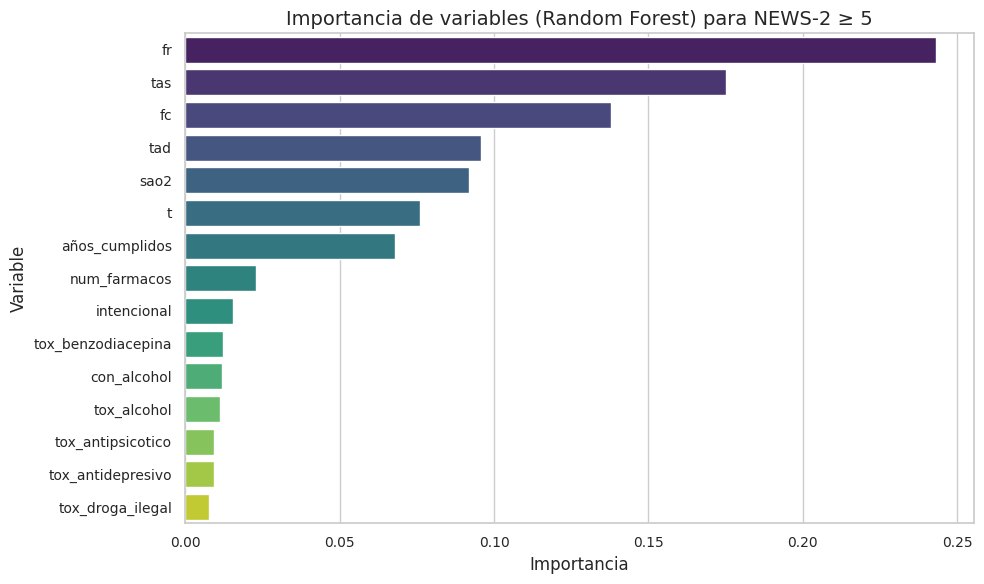

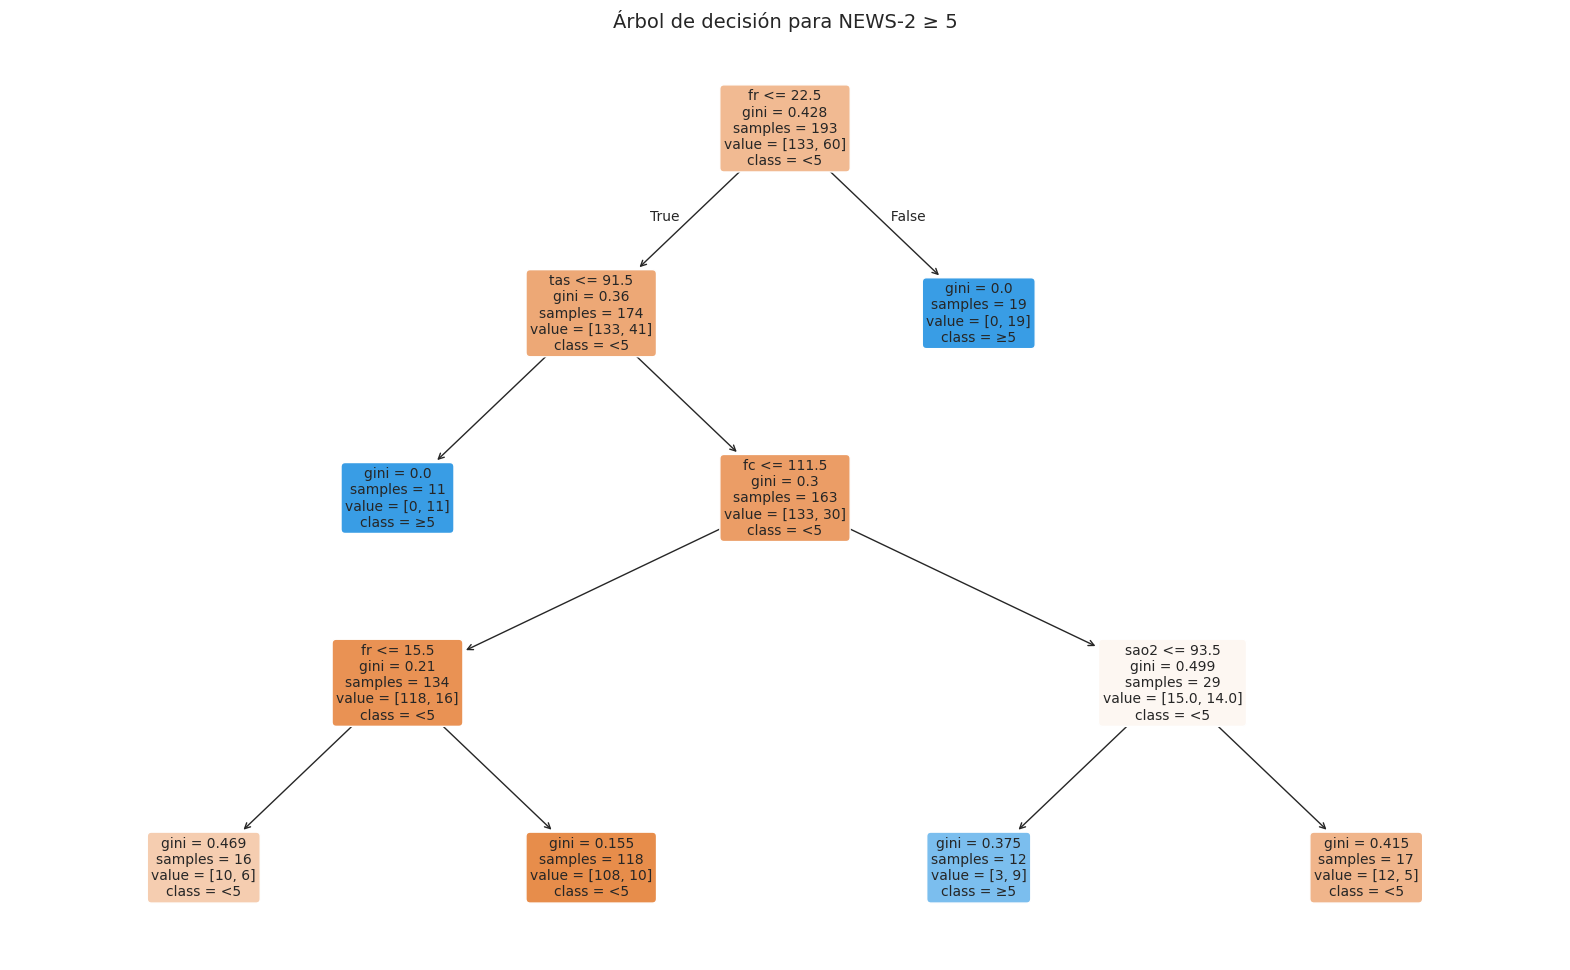


📈 Correlación de Spearman (relaciones monótonas):
                años_cumplidos   tas   tad    fc    fr     t  sao2  \
años_cumplidos            1.00  0.21  0.16 -0.07  0.13 -0.00 -0.12   
tas                       0.21  1.00  0.66  0.16  0.15  0.07 -0.07   
tad                       0.16  0.66  1.00  0.13  0.19  0.01 -0.01   
fc                       -0.07  0.16  0.13  1.00  0.04  0.19 -0.05   
fr                        0.13  0.15  0.19  0.04  1.00  0.05  0.09   
t                        -0.00  0.07  0.01  0.19  0.05  1.00  0.04   
sao2                     -0.12 -0.07 -0.01 -0.05  0.09  0.04  1.00   
news2_score              -0.06 -0.17 -0.06  0.32  0.21 -0.18 -0.41   
num_farmacos             -0.23 -0.20 -0.10 -0.09 -0.20 -0.19 -0.06   

                news2_score  num_farmacos  
años_cumplidos        -0.06         -0.23  
tas                   -0.17         -0.20  
tad                   -0.06         -0.10  
fc                     0.32         -0.09  
fr                     0.21 

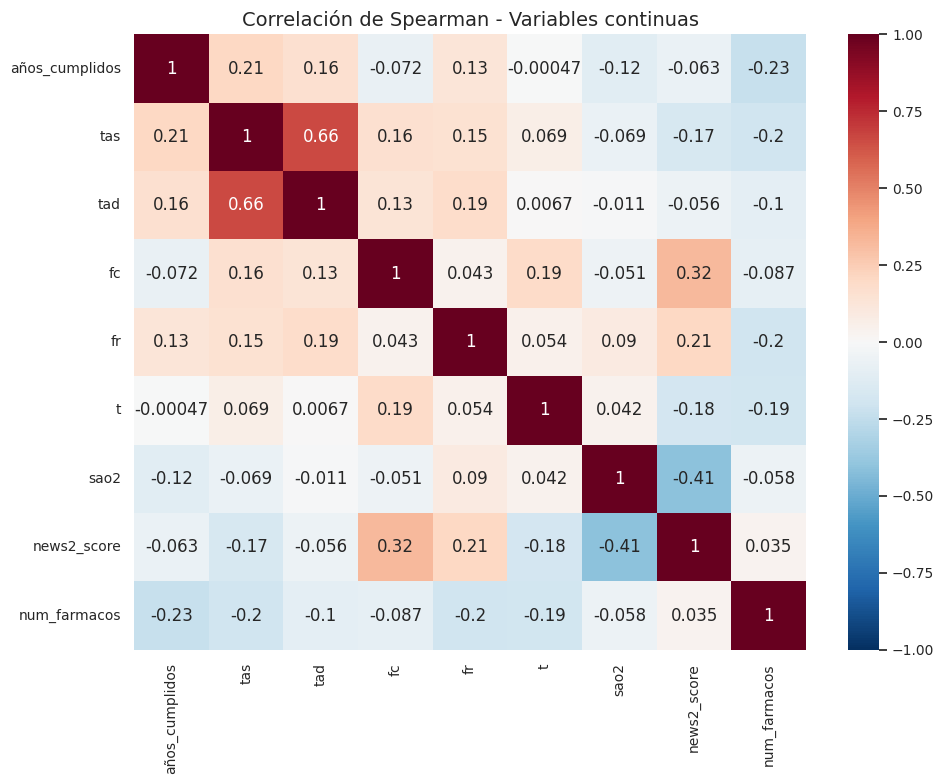


🕵️‍♂️ Información mutua entre pares de variables continuas:
años_cumplidos ↔ tas: MI = 2.353
años_cumplidos ↔ tad: MI = 2.091
años_cumplidos ↔ fc: MI = 2.468
años_cumplidos ↔ fr: MI = 1.221
años_cumplidos ↔ t: MI = 1.111
años_cumplidos ↔ sao2: MI = 0.955
años_cumplidos ↔ news2_score: MI = 0.864
años_cumplidos ↔ num_farmacos: MI = 0.341
tas ↔ tad: MI = 2.568
tas ↔ fc: MI = 2.872
tas ↔ fr: MI = 1.451
tas ↔ t: MI = 1.260
tas ↔ sao2: MI = 1.206
tas ↔ news2_score: MI = 1.117
tas ↔ num_farmacos: MI = 0.468
tad ↔ fc: MI = 2.607
tad ↔ fr: MI = 1.283
tad ↔ t: MI = 1.050
tad ↔ sao2: MI = 1.038
tad ↔ news2_score: MI = 1.078
tad ↔ num_farmacos: MI = 0.424
fc ↔ fr: MI = 1.638
fc ↔ t: MI = 1.366
fc ↔ sao2: MI = 1.260
fc ↔ news2_score: MI = 1.280
fc ↔ num_farmacos: MI = 0.559
fr ↔ t: MI = 0.640
fr ↔ sao2: MI = 0.493
fr ↔ news2_score: MI = 0.627
fr ↔ num_farmacos: MI = 0.215
t ↔ sao2: MI = 0.394
t ↔ news2_score: MI = 0.428
sao2 ↔ news2_score: MI = 0.446

🧬 Buscando fenotipos mediante clustering...


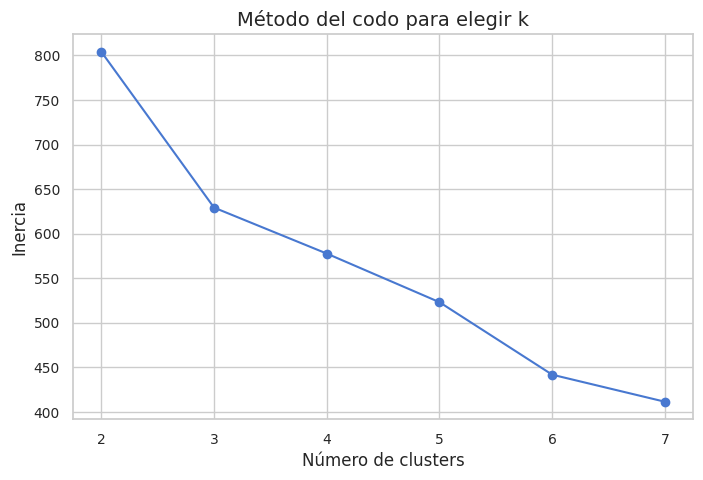

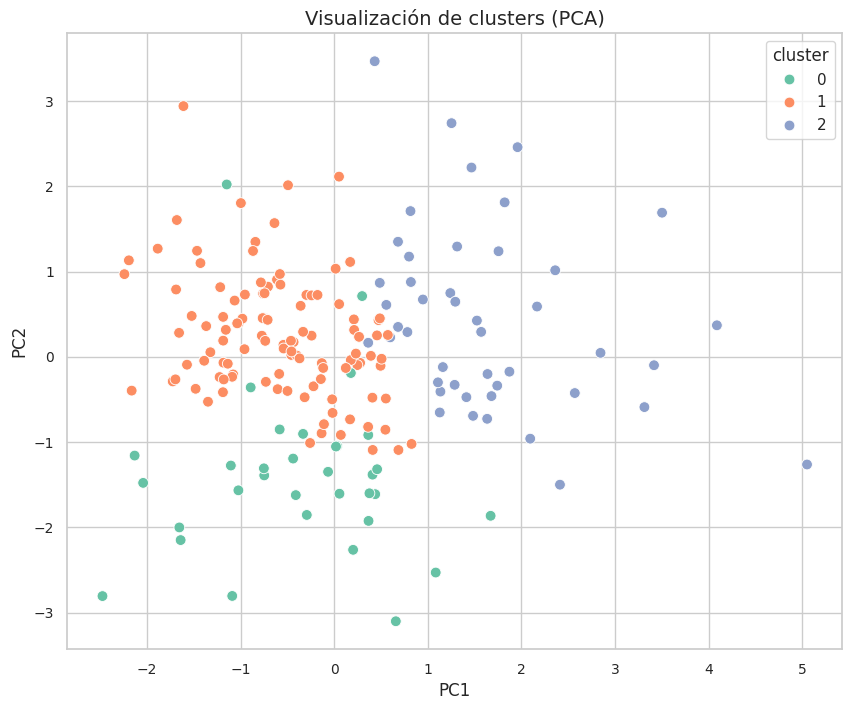


📊 Perfil promedio de cada cluster:
         años_cumplidos  news2_score     fc  sao2  num_farmacos
cluster                                                        
0                  26.2          3.5   85.4  94.4           2.3
1                  31.6          2.7   90.0  95.5           0.2
2                  37.6          6.4  107.2  91.7           0.3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Análisis completado. Se ha descargado 'analisis_exploratorio_resultados.zip' con todos los resultados.


In [ ]:
# ============================================
# 📊 SCRIPT 2 - ANÁLISIS EXPLORATORIO DE DATOS TOXICOLÓGICOS
# ============================================
# 1. Carga el CSV enriquecido (generado por SCRIPT 1)
# 2. Analiza predictores de NEWS-2 ≥ 5 (Random Forest, árbol de decisión)
# 3. Correlaciones robustas (Spearman) e información mutua
# 4. Clustering no supervisado (k-means) para fenotipos
# 5. Exporta resultados y visualizaciones
# ============================================

!pip install -q scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mutual_info_score
from scipy.stats import spearmanr
import io
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("🚀 INICIANDO ANÁLISIS EXPLORATORIO AVANZADO")
print("="*70)

# ------------------------------------------------------------
# 1. CARGA DEL CSV ENRIQUECIDO
# ------------------------------------------------------------
print("\n📁 PASO 1: Sube el archivo 'datos_toxicologia_enriquecidos.csv'")
uploaded = files.upload()
if not uploaded:
    raise Exception("❌ No se subió ningún archivo.")

filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
print(f"📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print("   Columnas disponibles:", list(df.columns))

# ------------------------------------------------------------
# 2. PREPARACIÓN DE DATOS PARA MODELADO
# ------------------------------------------------------------
# Variable objetivo: NEWS-2 alto (≥5)
df['news2_alto'] = (df['news2_score'] >= 5).astype(int)

# Seleccionar características para los modelos
features = ['años_cumplidos', 'tas', 'tad', 'fc', 'fr', 't', 'sao2'] + \
           [col for col in df.columns if col.startswith('tox_')] + \
           ['intencional', 'num_farmacos', 'con_alcohol']
features = [f for f in features if f in df.columns]

X = df[features].copy()
y = df['news2_alto'].copy()

# Eliminar filas con NaN en X o y
mask = y.notna() & X.notna().all(axis=1)
X = X[mask]
y = y[mask]
print(f"\n✅ Muestra para modelado: {X.shape[0]} casos, {X.shape[1]} características.")

# ------------------------------------------------------------
# 3. RANDOM FOREST - IMPORTANCIA DE VARIABLES
# ------------------------------------------------------------
print("\n🌲 Entrenando Random Forest para predecir NEWS-2 ≥ 5...")
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\n🌟 TOP 10 PREDICTORES DE NEWS-2 ≥ 5:")
print(importancias.head(10).to_string(index=False))

# Gráfico de importancia
plt.figure(figsize=(10,6))
sns.barplot(data=importancias.head(15), y='Variable', x='Importancia', palette='viridis')
plt.title('Importancia de variables (Random Forest) para NEWS-2 ≥ 5')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. ÁRBOL DE DECISIÓN - REGLAS INTERPRETABLES
# ------------------------------------------------------------
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=42)
dt.fit(X, y)

plt.figure(figsize=(20,12))
plot_tree(dt, feature_names=X.columns, class_names=['<5', '≥5'],
          filled=True, rounded=True, fontsize=10, proportion=False)
plt.title('Árbol de decisión para NEWS-2 ≥ 5')
plt.show()

# ------------------------------------------------------------
# 5. CORRELACIONES ROBUSTAS (SPEARMAN) CON MANEJO DE NAs
# ------------------------------------------------------------
print("\n📈 Correlación de Spearman (relaciones monótonas):")
continuas = ['años_cumplidos', 'tas', 'tad', 'fc', 'fr', 't', 'sao2', 'news2_score', 'num_farmacos']
continuas = [c for c in continuas if c in df.columns]

# Eliminar filas con NaN en TODAS las columnas simultáneamente
df_continuas = df[continuas].dropna()
corr_spearman = df_continuas.corr(method='spearman')
print(corr_spearman.round(2))

# Mapa de calor de Spearman
plt.figure(figsize=(10,8))
sns.heatmap(corr_spearman, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title('Correlación de Spearman - Variables continuas')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6. INFORMACIÓN MUTUA (DEPENDENCIA NO LINEAL)
# ------------------------------------------------------------
print("\n🕵️‍♂️ Información mutua entre pares de variables continuas:")
mi_results = []
for i, col1 in enumerate(continuas):
    for col2 in continuas[i+1:]:
        # Alinear datos sin NaN en ambas columnas
        temp = df[[col1, col2]].dropna()
        if len(temp) > 10:
            mi = mutual_info_score(temp[col1], temp[col2])
            if mi > 0.2:  # Umbral para mostrar
                mi_results.append({'Var1': col1, 'Var2': col2, 'MI': mi})
                print(f"{col1} ↔ {col2}: MI = {mi:.3f}")

# ------------------------------------------------------------
# 7. CLUSTERING DE PACIENTES (FENOTIPOS)
# ------------------------------------------------------------
print("\n🧬 Buscando fenotipos mediante clustering...")
# Seleccionar variables para clustering
cluster_vars = ['años_cumplidos', 'news2_score', 'fc', 'sao2', 'num_farmacos']
cluster_vars = [v for v in cluster_vars if v in df.columns]
df_cluster = df[cluster_vars].dropna().copy()

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Determinar número óptimo de clusters (método del codo)
inercias = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inercias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2,8), inercias, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo para elegir k')
plt.grid(True)
plt.show()

# Elegir k=3 (por ejemplo)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Visualizar clusters con PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
df_cluster['PC1'] = coords[:,0]
df_cluster['PC2'] = coords[:,1]

plt.figure(figsize=(10,8))
sns.scatterplot(data=df_cluster, x='PC1', y='PC2', hue='cluster', palette='Set2', s=60)
plt.title('Visualización de clusters (PCA)')
plt.show()

# Caracterizar clusters
cluster_profile = df_cluster.groupby('cluster')[cluster_vars].mean()
print("\n📊 Perfil promedio de cada cluster:")
print(cluster_profile.round(1))

# ------------------------------------------------------------
# 8. EXPORTAR RESULTADOS
# ------------------------------------------------------------
import zipfile
import os

# Guardar importancias
importancias.to_csv('importancia_variables_news2.csv', index=False)

# Guardar perfiles de clusters
cluster_profile.to_csv('perfiles_clusters.csv')

# Guardar matriz de correlación Spearman
corr_spearman.to_csv('correlacion_spearman.csv')

# Comprimir y descargar
with zipfile.ZipFile('analisis_exploratorio_resultados.zip', 'w') as zipf:
    zipf.write('importancia_variables_news2.csv')
    zipf.write('perfiles_clusters.csv')
    zipf.write('correlacion_spearman.csv')
files.download('analisis_exploratorio_resultados.zip')

print("\n✅ Análisis completado. Se ha descargado 'analisis_exploratorio_resultados.zip' con todos los resultados.")

In [ ]:
# ============================================
# 📈 DASHBOARD TOXICOLÓGICO AVANZADO - VERSIÓN FINAL
# ============================================
# Basado en el análisis exploratorio con:
#   - Clusters (k-means) de pacientes
#   - Importancia de variables (datos fijos)
#   - Nuevas variables: tox_*, intencional, num_farmacos, con_alcohol, tipo_toxico_principal
#   - Correlaciones de Spearman
#   - SIN ERRORES DE NaN
# ============================================

!pip install -q plotly kaleido pandas numpy scipy wordcloud nltk scikit-learn

import pandas as pd
import numpy as np
from datetime import datetime
import io
import base64
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Visualización
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Nube de palabras
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# NLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
spanish_stopwords = set(stopwords.words('spanish'))

# Estadística y ML
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from google.colab import files

print("🚀 GENERANDO DASHBOARD TOXICOLÓGICO AVANZADO - VERSIÓN FINAL")
print("="*80)

# ------------------------------------------------------------
# 1. CARGA DE DATOS
# ------------------------------------------------------------
print("\n📁 PASO 1: Sube tu archivo CSV ENRIQUECIDO")
print("-"*80)
uploaded = files.upload()
if not uploaded:
    raise Exception("❌ No se subió ningún archivo.")
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
df.columns = df.columns.str.strip()
print(f"📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")

# ------------------------------------------------------------
# 2. PREPROCESAMIENTO - MANEJO ROBUSTO DE NaN
# ------------------------------------------------------------
print("\n🛠️ Preprocesando datos...")

# Columnas numéricas - convertir y manejar NaN
num_cols = ['años_cumplidos', 'tas', 'tad', 'fc', 'fr', 't', 'sao2', 'gluc', 'news2_score', 'num_farmacos']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fecha/hora - manejo seguro
if 'fecha_atencion' in df.columns:
    try:
        df['fecha_dt'] = pd.to_datetime(df['fecha_atencion'], format='%d%m%y', errors='coerce')
        df['dia_semana'] = df['fecha_dt'].dt.day_name()
        df['mes'] = df['fecha_dt'].dt.month
    except:
        pass

if 'hora_atencion' in df.columns:
    try:
        df['hora'] = pd.to_datetime(df['hora_atencion'], format='%H:%M', errors='coerce').dt.hour
    except:
        pass

# Normalizar género
if 'genero' in df.columns:
    df['genero'] = df['genero'].astype(str).str.upper().map({
        'HOMBRE': 'Hombre', 'MUJER': 'Mujer'
    }).fillna(df['genero'].str.capitalize())

# Grupo etario
if 'años_cumplidos' in df.columns:
    df['grupo_edad'] = pd.cut(df['años_cumplidos'],
                               bins=[0, 18, 30, 45, 60, 100],
                               labels=['0-18', '19-30', '31-45', '46-60', '60+'])

# NEWS-2 alto (≥5) - manejar NaN
if 'news2_score' in df.columns:
    df['news2_alto'] = (df['news2_score'] >= 5).astype(int)
    df['news2_alto'] = df['news2_alto'].where(df['news2_score'].notna(), np.nan)

# ------------------------------------------------------------
# 3. ASIGNAR CLUSTERS (FENOTIPOS)
# ------------------------------------------------------------
print("\n🧬 Asignando fenotipos (clusters) a los pacientes...")

cluster_vars = ['años_cumplidos', 'news2_score', 'fc', 'sao2', 'num_farmacos']
cluster_vars = [v for v in cluster_vars if v in df.columns]
df_cluster = df[cluster_vars].dropna().copy()

if len(df_cluster) >= 10:
    # Estandarizar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    # Aplicar k-means con k=3
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # Calcular perfiles para asignar nombres lógicos
    df_cluster['cluster_temp'] = clusters
    perfiles = df_cluster.groupby('cluster_temp')[cluster_vars].mean()

    # Identificar clusters por características
    idx_grave = perfiles['news2_score'].idxmax()
    idx_poli = perfiles['num_farmacos'].idxmax()
    idx_leve = [i for i in range(3) if i not in [idx_grave, idx_poli]][0]

    cluster_map = {
        idx_poli: 'Cluster 0: Joven · Polifarmacia · NEWS‑2 moderado',
        idx_leve: 'Cluster 1: Adulto · Sin polifarmacia · NEWS‑2 bajo',
        idx_grave: 'Cluster 2: Mayor · Taquicardia/Hipoxemia · NEWS‑2 alto'
    }

    # Asignar clusters
    df['cluster'] = np.nan
    df.loc[df_cluster.index, 'cluster'] = [cluster_map[c] for c in clusters]

    print(f"✅ Clusters asignados para {len(df_cluster)} pacientes.")

    # Mostrar perfil
    cluster_profile = df.groupby('cluster')[cluster_vars].mean().round(1)
    print("\n   Perfil de clusters:")
    print(cluster_profile.to_string())
else:
    print("⚠️ No hay suficientes datos para clustering.")
    df['cluster'] = np.nan

# ------------------------------------------------------------
# 4. IMPORTANCIA DE VARIABLES (datos fijos del análisis)
# ------------------------------------------------------------
importancias_conocidas = {
    'Frecuencia respiratoria (FR)': 0.243,
    'Tensión arterial sistólica (TAS)': 0.175,
    'Frecuencia cardíaca (FC)': 0.138,
    'Tensión arterial diastólica (TAD)': 0.096,
    'Saturación de oxígeno (SpO₂)': 0.092,
    'Temperatura (T)': 0.076,
    'Edad': 0.068,
    'Número de fármacos': 0.023,
    'Intencionalidad': 0.015,
    'Benzodiacepinas': 0.012,
    'Co‑ingesta de alcohol': 0.012,
    'Alcohol': 0.011,
    'Antipsicóticos': 0.009,
    'Antidepresivos': 0.009,
    'Drogas ilegales': 0.008,
    'Analgésicos': 0.007,
    'Animales ponzoñosos': 0.003,
    'Plaguicidas': 0.002
}

df_importancias = pd.DataFrame([
    {'Variable': k, 'Importancia': v}
    for k, v in importancias_conocidas.items()
]).sort_values('Importancia', ascending=False)

# ------------------------------------------------------------
# 5. REGLA DE GRAVEDAD
# ------------------------------------------------------------
if 'fr' in df.columns and 'tas' in df.columns:
    df['regla_gravedad'] = ((df['fr'] > 22.5) & (df['tas'] <= 91.5)).astype(int)
    df['regla_gravedad'] = df['regla_gravedad'].where(df['fr'].notna() & df['tas'].notna(), np.nan)

# ------------------------------------------------------------
# 6. CORRELACIONES DE SPEARMAN
# ------------------------------------------------------------
print("\n📈 Calculando correlaciones de Spearman...")
spearman_cols = ['años_cumplidos', 'tas', 'tad', 'fc', 'fr', 't', 'sao2', 'news2_score', 'num_farmacos']
spearman_cols = [c for c in spearman_cols if c in df.columns]
df_spearman = df[spearman_cols].dropna()
corr_spearman = df_spearman.corr(method='spearman') if len(df_spearman) > 10 else pd.DataFrame()

# ------------------------------------------------------------
# 7. NUBE DE PALABRAS
# ------------------------------------------------------------
print("☁️ Generando nube de palabras...")
df['texto_completo'] = df['motivo_atencion'].fillna('') + ' ' + df['impresion_diagnostica'].fillna('')
texto_completo = ' '.join(df['texto_completo'].dropna().astype(str))
wordcloud_base64 = ""

if texto_completo.strip():
    try:
        wordcloud = WordCloud(width=800, height=400,
                              background_color='white',
                              max_words=50,
                              colormap='Blues',
                              collocations=False).generate(texto_completo)
        fig_wc, ax_wc = plt.subplots(figsize=(10, 5))
        ax_wc.imshow(wordcloud, interpolation='bilinear')
        ax_wc.axis('off')
        ax_wc.set_title('Nube de palabras en Motivo/Impresión', fontsize=16)
        buf = io.BytesIO()
        fig_wc.savefig(buf, format='png', bbox_inches='tight', dpi=100)
        buf.seek(0)
        wordcloud_base64 = base64.b64encode(buf.read()).decode()
        plt.close(fig_wc)
    except:
        pass

# ------------------------------------------------------------
# 8. CONSTRUCCIÓN DE FIGURAS - CON MANEJO DE NaN
# ------------------------------------------------------------
print("\n📝 Construyendo dashboard...")

COLOR_PRIMARY = "#2E86AB"
COLOR_SECONDARY = "#A23B72"
COLOR_ACCENT = "#F18F01"
COLOR_CLUSTER0 = "#2E86AB"
COLOR_CLUSTER1 = "#F18F01"
COLOR_CLUSTER2 = "#A23B72"
TEMPLATE = "plotly_white"

# --- FIGURA 1: Distribución de NEWS-2 ---
df_fig1 = df[df['news2_score'].notna()]
fig1 = px.histogram(df_fig1, x='news2_score', nbins=20,
                    title='Distribución de NEWS‑2',
                    labels={'news2_score': 'Puntaje NEWS‑2'},
                    color_discrete_sequence=[COLOR_PRIMARY], opacity=0.8)
fig1.update_layout(bargap=0.1, title_x=0.5, template=TEMPLATE)

# --- FIGURA 2: NEWS-2 por Género ---
fig2 = None
if 'genero' in df.columns and 'news2_score' in df.columns:
    df_fig2 = df[df['news2_score'].notna() & df['genero'].notna()]
    if len(df_fig2) > 5:
        fig2 = px.violin(df_fig2, x='genero', y='news2_score', box=True, points='all',
                         title='NEWS‑2 por Género', color='genero',
                         color_discrete_sequence=[COLOR_PRIMARY, COLOR_SECONDARY])
        fig2.update_layout(title_x=0.5, template=TEMPLATE, showlegend=False)

# --- FIGURA 3: NEWS-2 vs Edad ---
fig3 = None
if 'años_cumplidos' in df.columns and 'news2_score' in df.columns:
    df_fig3 = df[df['news2_score'].notna() & df['años_cumplidos'].notna()]
    if len(df_fig3) > 5:
        fig3 = px.scatter(df_fig3, x='años_cumplidos', y='news2_score',
                          color='genero' if 'genero' in df_fig3.columns else None,
                          trendline='lowess',
                          title='NEWS‑2 vs. Edad (suavizado)',
                          labels={'años_cumplidos': 'Edad (años)', 'news2_score': 'NEWS‑2'},
                          color_discrete_sequence=[COLOR_PRIMARY, COLOR_SECONDARY])
        fig3.update_layout(title_x=0.5, template=TEMPLATE)

# --- FIGURA 4: NEWS-2 por Grupo Etario ---
fig4 = None
if 'grupo_edad' in df.columns and 'news2_score' in df.columns:
    df_fig4 = df[df['news2_score'].notna() & df['grupo_edad'].notna()]
    if len(df_fig4) > 5:
        fig4 = px.box(df_fig4, x='grupo_edad', y='news2_score', color='grupo_edad',
                      title='NEWS‑2 por Grupo Etario',
                      color_discrete_sequence=px.colors.sequential.Viridis)
        fig4.update_layout(title_x=0.5, template=TEMPLATE, showlegend=False)

# --- FIGURA 5: Importancia de Variables ---
fig5 = go.Figure()
fig5.add_trace(go.Bar(
    y=df_importancias.head(12)['Variable'],
    x=df_importancias.head(12)['Importancia'],
    orientation='h',
    marker=dict(color=df_importancias.head(12)['Importancia'],
                colorscale='Blues', showscale=True,
                colorbar=dict(title="Importancia")),
    text=df_importancias.head(12)['Importancia'].round(3),
    textposition='outside'
))
fig5.update_layout(title='Top 12 predictores de NEWS‑2 ≥5 (Random Forest)',
                   xaxis_title='Importancia', yaxis_title='',
                   template=TEMPLATE, height=500)

# --- FIGURA 6: Regla de Gravedad ---
fig6 = None
if 'regla_gravedad' in df.columns and 'news2_alto' in df.columns:
    df_fig6 = df[df['regla_gravedad'].notna() & df['news2_alto'].notna()]
    if len(df_fig6) > 0:
        contingency = pd.crosstab(df_fig6['regla_gravedad'], df_fig6['news2_alto'])

        row0_vals = [0, 0, 0]
        row1_vals = [0, 0, 0]

        if 0 in contingency.index:
            row0_vals = [
                contingency.loc[0, 0] if 0 in contingency.columns else 0,
                contingency.loc[0, 1] if 1 in contingency.columns else 0,
                contingency.loc[0].sum()
            ]
        if 1 in contingency.index:
            row1_vals = [
                contingency.loc[1, 0] if 0 in contingency.columns else 0,
                contingency.loc[1, 1] if 1 in contingency.columns else 0,
                contingency.loc[1].sum()
            ]

        fig6 = go.Figure(data=[go.Table(
            header=dict(values=['Regla', 'NEWS‑2 <5', 'NEWS‑2 ≥5', 'Total', '% NEWS‑2 ≥5'],
                        fill_color=COLOR_PRIMARY, align='left',
                        font=dict(color='white', size=12)),
            cells=dict(values=[
                ['No cumple', 'Cumple'],
                [row0_vals[0], row1_vals[0]],
                [row0_vals[1], row1_vals[1]],
                [row0_vals[2], row1_vals[2]],
                [f"{row0_vals[1]/row0_vals[2]*100:.1f}%" if row0_vals[2]>0 else "0%",
                 f"{row1_vals[1]/row1_vals[2]*100:.1f}%" if row1_vals[2]>0 else "0%"]
            ], fill_color='lavender', align='left')
        )])
        fig6.update_layout(title='Regla de gravedad: FR > 22.5 y TAS ≤ 91.5',
                           template=TEMPLATE, height=250)

# --- FIGURA 7: Visualización de Clusters (PCA) ---
fig7 = None
if 'cluster' in df.columns and len(df['cluster'].dropna()) >= 10:
    cluster_vars_pca = ['años_cumplidos', 'news2_score', 'fc', 'sao2', 'num_farmacos']
    cluster_vars_pca = [v for v in cluster_vars_pca if v in df.columns]
    df_pca = df[cluster_vars_pca + ['cluster']].dropna()

    if len(df_pca) >= 10:
        X_pca = df_pca[cluster_vars_pca]
        scaler_pca = StandardScaler()
        X_scaled_pca = scaler_pca.fit_transform(X_pca)
        pca = PCA(n_components=2)
        coords = pca.fit_transform(X_scaled_pca)

        fig7 = px.scatter(x=coords[:, 0], y=coords[:, 1], color=df_pca['cluster'],
                          title='Visualización de fenotipos (clusters) - PCA',
                          labels={'x': 'CP1', 'y': 'CP2', 'color': 'Fenotipo'},
                          color_discrete_sequence=[COLOR_CLUSTER0, COLOR_CLUSTER1, COLOR_CLUSTER2])
        fig7.update_layout(template=TEMPLATE)

# --- FIGURA 8: Perfil de Clusters (Radar) ---
fig8 = None
if 'cluster' in df.columns and len(df['cluster'].dropna()) >= 10:
    radar_vars = ['años_cumplidos', 'news2_score', 'fc', 'sao2', 'num_farmacos']
    radar_vars = [v for v in radar_vars if v in df.columns]
    df_radar = df[radar_vars + ['cluster']].dropna()

    if len(df_radar) >= 10:
        profile = df_radar.groupby('cluster')[radar_vars].mean().reset_index()

        # Normalizar 0-1
        profile_norm = profile.copy()
        for var in radar_vars:
            min_val = profile[var].min()
            max_val = profile[var].max()
            if max_val > min_val:
                profile_norm[var] = (profile[var] - min_val) / (max_val - min_val)
            else:
                profile_norm[var] = 0.5

        fig8 = go.Figure()
        for _, row in profile_norm.iterrows():
            fig8.add_trace(go.Scatterpolar(
                r=[row[var] for var in radar_vars],
                theta=radar_vars,
                fill='toself',
                name=row['cluster']
            ))
        fig8.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
                           title='Perfil de fenotipos (normalizado)',
                           template=TEMPLATE)

# --- FIGURA 9: Tipo de tóxico principal ---
fig9 = None
if 'tipo_toxico_principal' in df.columns:
    tox_counts = df['tipo_toxico_principal'].value_counts().reset_index()
    tox_counts.columns = ['tipo', 'casos']
    fig9 = px.bar(tox_counts, x='tipo', y='casos',
                  title='Distribución por tipo de tóxico principal',
                  color='casos', color_continuous_scale='Blues', text='casos')
    fig9.update_layout(title_x=0.5, template=TEMPLATE, xaxis_tickangle=-45)

# --- FIGURA 10: NEWS-2 según intencionalidad ---
fig10 = None
if 'intencional' in df.columns and 'news2_score' in df.columns:
    df_fig10 = df[df['news2_score'].notna() & df['intencional'].notna()]
    if len(df_fig10) > 5:
        fig10 = px.box(df_fig10, x='intencional', y='news2_score',
                       title='NEWS‑2 según intencionalidad (0=No, 1=Sí)',
                       labels={'intencional': 'Intencional', 'news2_score': 'NEWS‑2'},
                       color='intencional',
                       color_discrete_sequence=[COLOR_PRIMARY, COLOR_SECONDARY])
        fig10.update_layout(title_x=0.5, template=TEMPLATE, showlegend=False)

# --- FIGURA 11: Polifarmacia vs Edad ---
fig11 = None
if all(v in df.columns for v in ['num_farmacos', 'años_cumplidos', 'news2_score']):
    df_fig11 = df[df['news2_score'].notna() & df['años_cumplidos'].notna() & df['num_farmacos'].notna()]
    if len(df_fig11) > 5:
        fig11 = px.scatter(df_fig11, x='años_cumplidos', y='num_farmacos',
                           size='news2_score', color='news2_score',
                           title='Polifarmacia vs Edad (tamaño = NEWS‑2)',
                           labels={'años_cumplidos': 'Edad', 'num_farmacos': 'Nº fármacos'},
                           color_continuous_scale='Reds', size_max=15)
        fig11.update_layout(title_x=0.5, template=TEMPLATE)

# --- FIGURA 12: Correlación Spearman ---
fig12 = None
if not corr_spearman.empty:
    fig12 = px.imshow(corr_spearman, text_auto=True, aspect='auto',
                      title='Matriz de correlación (Spearman)',
                      color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
    fig12.update_layout(title_x=0.5, template=TEMPLATE, height=600)

# --- FIGURA 13: Co-ingesta de alcohol ---
fig13 = None
if 'con_alcohol' in df.columns and 'news2_score' in df.columns:
    df_fig13 = df[df['news2_score'].notna() & df['con_alcohol'].notna()]
    if len(df_fig13) > 5:
        fig13 = px.violin(df_fig13, x='con_alcohol', y='news2_score', box=True,
                          title='NEWS‑2 según co‑ingesta de alcohol',
                          labels={'con_alcohol': 'Con alcohol', 'news2_score': 'NEWS‑2'},
                          color='con_alcohol',
                          color_discrete_sequence=[COLOR_PRIMARY, COLOR_ACCENT])
        fig13.update_layout(title_x=0.5, template=TEMPLATE, showlegend=False)

# --- FIGURA 14: Atenciones por hora ---
fig14 = None
if 'hora' in df.columns:
    hora_counts = df['hora'].value_counts().sort_index().reset_index()
    hora_counts.columns = ['hora', 'casos']
    fig14 = px.bar(hora_counts, x='hora', y='casos',
                   title='Atenciones por Hora del Día',
                   labels={'hora': 'Hora', 'casos': 'Número de casos'},
                   color_discrete_sequence=[COLOR_ACCENT])
    fig14.update_layout(title_x=0.5, template=TEMPLATE)

# --- FIGURA 15: Treemap de entidades ---
fig15 = None
if 'entidad' in df.columns and df['entidad'].notna().any():
    entidad_counts = df['entidad'].value_counts().reset_index()
    entidad_counts.columns = ['entidad', 'casos']
    fig15 = px.treemap(entidad_counts, path=['entidad'], values='casos',
                       title='Distribución Geográfica de Casos',
                       color='casos', color_continuous_scale='Blues')
    fig15.update_layout(title_x=0.5, template=TEMPLATE)

# ------------------------------------------------------------
# 9. CONSTRUCCIÓN DEL HTML
# ------------------------------------------------------------
def fig_to_html_card(fig):
    if fig is None:
        return ""
    try:
        return f'<div class="card">{fig.to_html(full_html=False, include_plotlyjs=False)}</div>'
    except:
        return ""

print("🖌️ Ensamblando dashboard...")

# Métricas para tarjetas
total_casos = len(df)
hombres = df['genero'].value_counts().get('Hombre', 0) if 'genero' in df.columns else 0
mujeres = df['genero'].value_counts().get('Mujer', 0) if 'genero' in df.columns else 0
edad_mediana = df['años_cumplidos'].median() if 'años_cumplidos' in df.columns else 0
news2_promedio = df['news2_score'].mean() if 'news2_score' in df.columns else 0
intentos = df['intencional'].sum() if 'intencional' in df.columns else 0

html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Dashboard Toxicológico Avanzado</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {{
            font-family: 'Inter', -apple-system, BlinkMacSystemFont, sans-serif;
            background-color: #f9f9fb;
            margin: 0;
            padding: 25px;
        }}
        .dashboard {{
            max-width: 1800px;
            margin: 0 auto;
        }}
        h1 {{
            color: {COLOR_PRIMARY};
            font-weight: 600;
            border-bottom: 4px solid {COLOR_ACCENT};
            padding-bottom: 8px;
        }}
        h2 {{
            color: {COLOR_SECONDARY};
            font-weight: 600;
            margin-top: 40px;
            border-left: 8px solid {COLOR_ACCENT};
            padding-left: 16px;
        }}
        .stats-grid {{
            display: flex;
            flex-wrap: wrap;
            gap: 20px;
            margin: 30px 0;
        }}
        .stat-card {{
            background: white;
            border-radius: 14px;
            padding: 20px 25px;
            box-shadow: 0 8px 20px rgba(0,0,0,0.02);
            border-top: 6px solid {COLOR_ACCENT};
            flex: 1 1 160px;
        }}
        .stat-number {{
            font-size: 2.2rem;
            font-weight: 700;
            color: {COLOR_PRIMARY};
            line-height: 1.2;
        }}
        .stat-label {{
            font-size: 0.85rem;
            text-transform: uppercase;
            color: #5f6b7a;
            letter-spacing: 0.5px;
        }}
        .grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(650px, 1fr));
            gap: 25px;
            margin-top: 30px;
        }}
        .card {{
            background: white;
            border-radius: 18px;
            padding: 20px;
            box-shadow: 0 12px 30px rgba(0,0,0,0.03);
            border: 1px solid #edf2f7;
            transition: all 0.2s;
        }}
        .card:hover {{
            box-shadow: 0 18px 40px rgba(0,0,0,0.05);
        }}
        .table-container {{
            overflow-x: auto;
            margin: 25px 0;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            font-size: 0.9rem;
            background: white;
            border-radius: 14px;
        }}
        th {{
            background-color: {COLOR_PRIMARY};
            color: white;
            padding: 12px 10px;
            font-weight: 600;
        }}
        td {{
            padding: 10px;
            border-bottom: 1px solid #e2e8f0;
        }}
        .footer {{
            margin-top: 50px;
            text-align: center;
            color: #64748b;
            border-top: 1px solid #e2e8f0;
            padding-top: 25px;
            font-size: 0.8rem;
        }}
        .insight-box {{
            background: #e6f7ff;
            border-left: 6px solid #1890ff;
            padding: 18px;
            border-radius: 12px;
            margin-bottom: 25px;
        }}
        .cluster0 {{ color: {COLOR_CLUSTER0}; font-weight: 600; }}
        .cluster1 {{ color: {COLOR_CLUSTER1}; font-weight: 600; }}
        .cluster2 {{ color: {COLOR_CLUSTER2}; font-weight: 600; }}
    </style>
</head>
<body>
    <div class="dashboard">
        <h1>🧪 Dashboard Toxicológico Avanzado · Fenotipos y Hallazgos</h1>
        <p style="color: #475569; font-size: 1.1rem;">
            {datetime.now().strftime('%d/%m/%Y %H:%M')} · {total_casos} casos · NEWS‑2 disponible en {df['news2_score'].notna().sum()} pacientes
        </p>

        <!-- Tarjetas de resumen -->
        <div class="stats-grid">
            <div class="stat-card"><span class="stat-number">{total_casos}</span><div class="stat-label">Total casos</div></div>
            <div class="stat-card"><span class="stat-number">{hombres}</span><div class="stat-label">Hombres</div></div>
            <div class="stat-card"><span class="stat-number">{mujeres}</span><div class="stat-label">Mujeres</div></div>
            <div class="stat-card"><span class="stat-number">{edad_mediana:.0f}</span><div class="stat-label">Edad mediana</div></div>
            <div class="stat-card"><span class="stat-number">{news2_promedio:.1f}</span><div class="stat-label">NEWS‑2 promedio</div></div>
            <div class="stat-card"><span class="stat-number">{intentos}</span><div class="stat-label">Intentos suicidas</div></div>
        </div>

        <!-- Hallazgos clave -->
        <div class="insight-box">
            <strong>🔬 HALLAZGOS CLAVE DEL ANÁLISIS:</strong><br>
            • <strong>Frecuencia respiratoria (FR)</strong> es el predictor más importante de gravedad.<br>
            • <strong>Regla de gravedad:</strong> FR > 22.5 y TAS ≤ 91.5 → alta probabilidad de NEWS‑2 ≥5.<br>
            • <strong>Tres fenotipos identificados:</strong><br>
            &nbsp;&nbsp;<span class="cluster0">● Cluster 0:</span> Joven, polifarmacia, NEWS‑2 moderado.<br>
            &nbsp;&nbsp;<span class="cluster1">● Cluster 1:</span> Adulto, sin polifarmacia, NEWS‑2 bajo.<br>
            &nbsp;&nbsp;<span class="cluster2">● Cluster 2:</span> Mayor, taquicardia/hipoxemia, NEWS‑2 alto.<br>
            • <strong>Polifarmacia</strong> se correlaciona negativamente con edad y NO predice gravedad.<br>
            • <strong>Intencionalidad</strong> no es factor de riesgo independiente para NEWS‑2 alto.
        </div>

        <!-- Sección de Fenotipos -->
        <h2>🧬 ANÁLISIS DE FENOTIPOS</h2>
        <div class="grid">
            {fig_to_html_card(fig7)}
            {fig_to_html_card(fig8)}
        </div>

        <!-- Sección de Predictores -->
        <h2>📊 PREDICTORES DE GRAVEDAD</h2>
        <div class="grid">
            {fig_to_html_card(fig5)}
            {fig_to_html_card(fig6)}
            {fig_to_html_card(fig1)}
            {fig_to_html_card(fig2)}
            {fig_to_html_card(fig3)}
            {fig_to_html_card(fig4)}
            {fig_to_html_card(fig12)}
        </div>

        <!-- Sección de Nuevas Variables -->
        <h2>🔬 VARIABLES SEMÁNTICAS</h2>
        <div class="grid">
            {fig_to_html_card(fig9)}
            {fig_to_html_card(fig10)}
            {fig_to_html_card(fig11)}
            {fig_to_html_card(fig13)}
        </div>

        <!-- Sección de Contexto -->
        <h2>📍 CONTEXTO DEMOGRÁFICO Y TEMPORAL</h2>
        <div class="grid">
            {fig_to_html_card(fig14)}
            {fig_to_html_card(fig15)}
        </div>

        <!-- Nube de palabras -->
        <h2>☁️ ANÁLISIS DE TEXTO</h2>
        <div class="grid">
            <div class="card">
                <h3 style="margin-top:0; color:{COLOR_PRIMARY};">Nube de palabras</h3>
                <img src="data:image/png;base64,{wordcloud_base64}" style="width:100%; border-radius:12px;">
            </div>
        </div>

        <!-- Tabla de Importancias -->
        <h2>📋 IMPORTANCIA DE VARIABLES (RANDOM FOREST)</h2>
        <div class="grid">
            <div class="card" style="grid-column: 1/-1;">
                <div class="table-container">
                    {df_importancias.to_html(index=False, classes='table', border=0, escape=False)}
                </div>
            </div>
        </div>
"""

# Tabla de perfiles de clusters
if 'cluster' in df.columns and len(df['cluster'].dropna()) > 0:
    cluster_vars_table = ['años_cumplidos', 'news2_score', 'fc', 'sao2', 'num_farmacos']
    cluster_vars_table = [v for v in cluster_vars_table if v in df.columns]
    cluster_profile_table = df.groupby('cluster')[cluster_vars_table].mean().round(1)
    html_content += f"""
        <h2>📊 PERFIL DE FENOTIPOS</h2>
        <div class="grid">
            <div class="card" style="grid-column: 1/-1;">
                <div class="table-container">
                    {cluster_profile_table.to_html(classes='table', border=0, escape=False)}
                </div>
            </div>
        </div>
    """

html_content += """
        <div class="footer">
            Dashboard generado automáticamente · Análisis de intoxicaciones agudas · Datos enriquecidos con variables semánticas y clustering.
            <br>Desarrollado para investigación clínica en toxicología.
        </div>
    </div>
</body>
</html>
"""

# ------------------------------------------------------------
# 10. GUARDAR Y DESCARGAR
# ------------------------------------------------------------
html_filename = f"dashboard_toxicologico_avanzado_{datetime.now().strftime('%Y%m%d_%H%M%S')}.html"
with open(html_filename, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"\n💾 Dashboard guardado: {html_filename}")
print("\n⬇️ DESCARGANDO...")
files.download(html_filename)

print("\n🎯 ¡PROCESO COMPLETADO! El dashboard se ha descargado automáticamente.")
print("   Ábrelo en cualquier navegador para explorar los datos.")

🚀 GENERANDO DASHBOARD TOXICOLÓGICO AVANZADO - VERSIÓN FINAL

📁 PASO 1: Sube tu archivo CSV ENRIQUECIDO
--------------------------------------------------------------------------------


Saving db-cinder-tox-mod.csv to db-cinder-tox-mod.csv
📊 Dimensiones: 195 filas × 34 columnas

🛠️ Preprocesando datos...

🧬 Asignando fenotipos (clusters) a los pacientes...
✅ Clusters asignados para 188 pacientes.

   Perfil de clusters:
                                                        años_cumplidos  news2_score     fc  sao2  num_farmacos
cluster                                                                                                       
Cluster 0: Joven · Polifarmacia · NEWS‑2 moderado                 26.8          3.8   86.7  94.2           2.1
Cluster 1: Adulto · Sin polifarmacia · NEWS‑2 bajo                33.9          2.4   83.3  95.2           0.1
Cluster 2: Mayor · Taquicardia/Hipoxemia · NEWS‑2 alto            33.2          5.8  114.4  93.2           0.2

📈 Calculando correlaciones de Spearman...
☁️ Generando nube de palabras...

📝 Construyendo dashboard...
🖌️ Ensamblando dashboard...

💾 Dashboard guardado: dashboard_toxicologico_avanzado_20260211_215046.htm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 ¡PROCESO COMPLETADO! El dashboard se ha descargado automáticamente.
   Ábrelo en cualquier navegador para explorar los datos.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')